In [1]:
import os, math
from enum import StrEnum, auto
from collections import defaultdict, namedtuple, Counter
import itertools
import sqlite3
import pickle
import datetime
import multiprocessing as mp
import gc
import json
from IPython.core.getipython import get_ipython

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from module.utils import *
from module.hdc import *
from module.constants import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_2_4096'
config = Config(config_var)
RNG = np.random.default_rng()
mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, 'fork' method leads to failures in bootstrap somewhere around CUDA

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()

print(f'xp = {xp.__name__}')

with open(get_ipython().kernel.config['IPKernelApp']['connection_file'], 'r') as cf:
    notebook_fname = json.load(cf)['jupyter_session']
    notebook_fname = os.path.basename(notebook_fname)

print(notebook_fname)

hdc = Hdc(10_000, xp)

xp = numpy
mnist_recognition59.ipynb


In [3]:
%run sequencing_sp2.ipynb

# Open DB

In [4]:
%time
train_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.train_db_file_name))
test_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_db_file_name))
test_results_db_con = sqlite3.connect(DBUtils.get_full_db_file_name(config, config.test_results_db_file_name, with_prefix=False), autocommit=True)

if not DBUtils.is_table_exists(test_results_db_con, 'test_runs'):
    test_results_db_con.execute('CREATE TABLE test_runs(test_run_id INTEGER PRIMARY KEY, dummy)')

df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.81 μs


((10000, 7), (2000, 7))


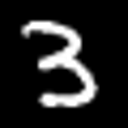
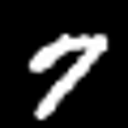
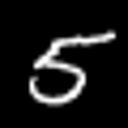
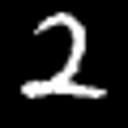
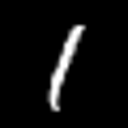
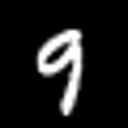
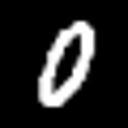
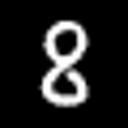
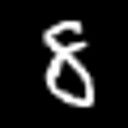
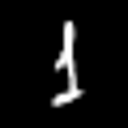
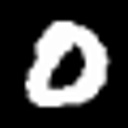
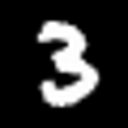
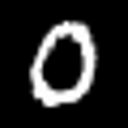
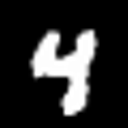
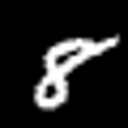
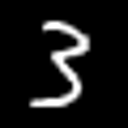

In [5]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

# Core logic

## Hyper Parameters

In [6]:
HP_SEQ_LV_COS_SIM_THRESHOLD = COS_SIM_45
HP_COMBI_SPACE_SIZE = 32
HP_SIGNAL_LEARN_OBSERVATIONS_COUNT_TRHES = 1
HP_SIGNAL_PC_BINARIZE_THRES = 0.75

## Types

In [7]:
class SignalState(StrEnum):
    LEARN = auto()
    PROD = auto()
    DEAD = auto()

class SignalFlag(StrEnum):
    IS_NEW_OBSERVATION = auto()
    TRUE_POSITIVES_CTR = auto()
    FALSE_POSITIVES_CTR = auto()

Signal = namedtuple('Signal', 
                    ['seq_lv_ind',
                     'image_id',
                     'value',
                     'seq_reading_code', 
                     'seq_reading',
                     'si_ind_dict',
                     'state',
                     'observations',
                     'flags',
                     'pcs',
                     'pc_ones_counts',
                     'pc_ind_to_cs_cluster_inds'], defaults=[None] * 3)

SignalObservation = namedtuple('SignalObservation', 
                               ['image_id', 
                                'cos_sim',
                                'value',
                                'is_correct_match', 
                                'seq_reading_code', 
                                'seq_reading', 
                                'si_ind_dict'])

Matchee = namedtuple('Matchee', 
                     ['image_id',
                      'value',
                      'seq_lvs',
                      'seq_reading_codes', 
                      'sequences', 
                      'si_ind_dict'])

## Memory

In [8]:
SEQ_INGRESS_SUBLV_LEN = 150
SEQ_SEQ_SUBLV_LEN = 300
SEQ_SUBLV_LEN = SEQ_INGRESS_SUBLV_LEN + SEQ_SEQ_SUBLV_LEN
SEQ_SUBLVS_COUNT = 5
SEQ_LV_LEN = SEQ_SUBLV_LEN * SEQ_SUBLVS_COUNT

SEQ_LVS = HdvArray(SEQ_LV_LEN * 2, xp, dtype='f') # aka ligands
SIGNALS = {} # key - seq_lv_ind, value - Signal instance

MATCHEE_CACHE = {} # key - image_id, value - Matchee
CPAV_CACHE = {} # key - (image_id, seq_reading_code, origin_offset), value - corresponding combinatorial point activations vector (CPAV)

In [9]:
def gc_memory():
    gc.collect()
    
    if cp.cuda.is_available():
        cp.get_default_memory_pool().free_all_blocks()

def clear_memory(with_caches=False):
    SEQ_LVS.clear()
    SIGNALS.clear()

    if with_caches:
        MATCHEE_CACHE.clear()
        CPAV_CACHE.clear()
    
    gc_memory()

## Combinatorial Space (CS)

In [10]:
CS_POINTS = []

patterns = [
    np.ones((5, 5), dtype='f'), # square
    np.ones((8, 3), dtype='f'), # horz bar (8x3)
    np.ones((3, 8), dtype='f'), # vert bar (3x8)
]
min_point_size = np.min(np.array(list(map(lambda p: p.shape, patterns))))
max_point_size = np.max(np.array(list(map(lambda p: p.shape, patterns))))
meshgrid = np.mgrid[0:HP_COMBI_SPACE_SIZE-min_point_size:2, 0:HP_COMBI_SPACE_SIZE-min_point_size:2]

for x, y in zip(meshgrid[1].ravel(), meshgrid[0].ravel()):
    for pattern in patterns:
        point = np.zeros((HP_COMBI_SPACE_SIZE + max_point_size, HP_COMBI_SPACE_SIZE + max_point_size), dtype='f')
        point[y:y+pattern.shape[0],x:x+pattern.shape[1]] = pattern
        point = point[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
        CS_POINTS.append(point.ravel())

CS_POINTS = xp.vstack(CS_POINTS)
CS_POINTS.shape

(675, 1024)

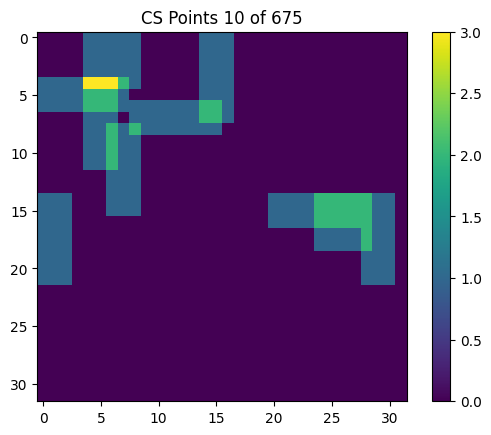

In [11]:
point_inds = RNG.choice(CS_POINTS.shape[0], 10, replace=False)
points_to_show = CS_POINTS[point_inds].sum(axis=0)
plt.imshow(points_to_show.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.title(f'CS Points {len(point_inds)} of {CS_POINTS.shape[0]}')
plt.colorbar()
plt.show()

In [12]:
CS_CLUSTERS = []

sz = HP_COMBI_SPACE_SIZE
probe_area_size = sz // 2
meshgrid = np.mgrid[0:sz-sz//4:sz//6,0:sz-sz//4:sz//6]

for x, y in zip(meshgrid[1].ravel(), meshgrid[0].ravel()):
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size, HP_COMBI_SPACE_SIZE + probe_area_size), dtype='f')
    probe_area[y:y+probe_area_size,x:x+probe_area_size] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

probe_area_size_h = sz
probe_area_size_v = sz // 4
meshgrid = np.mgrid[0:sz-sz//4:sz//6]

for y in meshgrid.ravel():
    x = 0
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size_v, HP_COMBI_SPACE_SIZE + probe_area_size_h), dtype='f')
    probe_area[y:y+probe_area_size_v,x:x+probe_area_size_h] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

probe_area_size_h = sz // 4
probe_area_size_v = sz
meshgrid = np.mgrid[0:sz-sz//4:sz//6]

for x in meshgrid.ravel():
    y = 0
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size_v, HP_COMBI_SPACE_SIZE + probe_area_size_h), dtype='f')
    probe_area[y:y+probe_area_size_v,x:x+probe_area_size_h] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

probe_area_size_h = sz
probe_area_size_v = sz // 10
meshgrid = np.mgrid[0:sz-sz//10:sz//8]

for y in meshgrid.ravel():
    x = 0
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size_v, HP_COMBI_SPACE_SIZE + probe_area_size_h), dtype='f')
    probe_area[y:y+probe_area_size_v,x:x+probe_area_size_h] = 1
    probe_area[y+probe_area_size_v*4:y+probe_area_size_v*5,x:x+probe_area_size_h] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

probe_area_size_h = sz // 10
probe_area_size_v = sz
meshgrid = np.mgrid[0:sz-sz//10:sz//8]

for x in meshgrid.ravel():
    y = 0
    probe_area = np.zeros((HP_COMBI_SPACE_SIZE + probe_area_size_v, HP_COMBI_SPACE_SIZE + probe_area_size_h), dtype='f')
    probe_area[y:y+probe_area_size_v,x:x+probe_area_size_h] = 1
    probe_area[y:y+probe_area_size_v,x+probe_area_size_h*4:x+probe_area_size_h*5] = 1
    probe_area = probe_area[0:HP_COMBI_SPACE_SIZE,0:HP_COMBI_SPACE_SIZE]
    points_in_probe_area = probe_area.ravel() @ CS_POINTS.T
    cluster = (points_in_probe_area > 0).astype('f')
    CS_CLUSTERS.append(cluster)

CS_CLUSTERS = xp.vstack(CS_CLUSTERS)
CS_CLUSTER_ONES_COUNTS = (CS_CLUSTERS > 0).sum(axis=1)
CS_CLUSTER_NUS = 1 / CS_CLUSTER_ONES_COUNTS
CS_CLUSTERS.shape, CS_CLUSTER_NUS.shape

((51, 675), (51,))

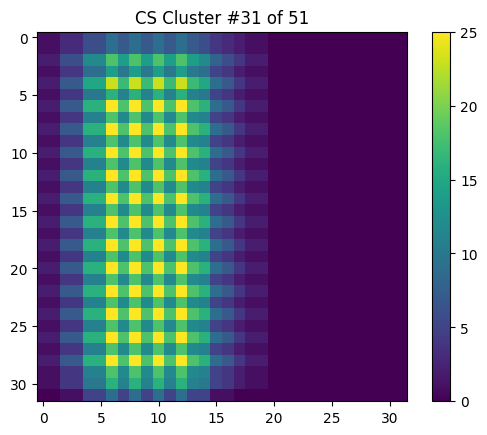

In [13]:
# cluster_ind = 1
cluster_ind = RNG.choice(len(CS_CLUSTERS))
cluster = CS_CLUSTERS[cluster_ind]
points_to_show = (CS_POINTS.T * cluster).T.sum(axis=0)
plt.imshow(points_to_show.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.title(f'CS Cluster #{cluster_ind} of {len(CS_CLUSTERS)}')
plt.colorbar()
plt.show()

## lambdas

In [14]:
fetch_si_xy = lambda si: (si.x, si.y)
get_sequence = lambda sequences: np.array(list(itertools.chain.from_iterable(sequences)))
get_sequences_reading = lambda sequences, seq_reading_code: list(map(lambda r: sequences[r[0]] if r[1] == 0 else list(reversed(sequences[r[0]])), seq_reading_code))
get_xy_sequence = lambda sequence, si_ind_dict: np.array(list(map(lambda si_ind: fetch_si_xy(si_ind_dict[si_ind]), sequence)))
get_raw_image = lambda image_id: Image.open(io.BytesIO((df_train_images if image_id < 100_000_000 else df_test_images).loc[image_id]['png']))
get_cs_point_activations_vec = lambda seq_bv: ((CS_POINTS @ seq_bv) > 0).astype('f')

## calc_seq_lv

In [15]:
def calc_seq_lv(sequences, si_ind_dict, seq_sublv_cache={}):
    seq_lv = np.zeros((SEQ_SUBLVS_COUNT, SEQ_SUBLV_LEN, 2), dtype='f')
    assert sequences
    assert len(sequences) <= SEQ_SUBLVS_COUNT, len(sequences)

    xy_prev_seq_tail = np.zeros(2)
    
    for sequence_i, (sequence, sublv) in enumerate(zip(sequences, seq_lv)):
        ingress_sublv = sublv[:SEQ_INGRESS_SUBLV_LEN]
        seq_sublv = sublv[SEQ_INGRESS_SUBLV_LEN:]
        
        assert sequence
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence0 = xy_sequence[0].copy()
        xy_sequence_last = xy_sequence[-1].copy()
        xy_sequence -= xy_sequence0
        
        # 1) Ingress component of sublv, for very first sequence (sublv) there is no ingress 
        if sequence_i > 0:
            ingress_vec = xy_sequence0 - xy_prev_seq_tail
            ingress_vec_len = int(np.round(np.linalg.norm(ingress_vec), decimals=0))
    
            if ingress_vec_len > 0:
                assert ingress_vec_len <= ingress_sublv.shape[0], ingress_vec_len
                ingress_sublv[:ingress_vec_len] = ingress_vec / ingress_vec_len
    
        # Remember tip last position so we would be able to compute
        # ingress vec for next seq RELATIVELY!!! (from tail to tip, not from beginning of whole figure)
        xy_prev_seq_tail = xy_sequence_last

        # 2) Seq component of sublv. 
        # At first check in cache - chances are that we've already done computation of seq_sublv.
        # Key for cache is starting si_ind. The bid here is that we have no duplicate si_ind within figure, 
        # as such each sub_lv is uniquely identified by starting si_ind
        starting_si_ind = sequence[0]

        if starting_si_ind in seq_sublv_cache:
            seq_sublv[:] = seq_sublv_cache[starting_si_ind]
        else:
            vec_sequence = np.roll(xy_sequence, -1, axis=0) - xy_sequence
            vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
            vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
            vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
            norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
            
            assert len(sequence) == vec_sequence.shape[0]
            assert len(sequence) == vec_len_sequence.shape[0]
            assert len(sequence) == norm_vec_sequence.shape[0]
            
            seq_len = vec_len_sequence.sum()
    
            if seq_len > 0:
                assert seq_len <= seq_sublv.shape[0], seq_len
                
                i = 0
                i_from = 0
                i_to = 0
        
                for si_ind, norm_vec, vec_len in zip(sequence, norm_vec_sequence, vec_len_sequence):
                    if vec_len > 0:
                        i += vec_len
                        i_to = min(int(i), seq_sublv.shape[0])
                        assert i_from >= 0, i_from
                        assert i_to >= i_from, (i_to, i_from)
                        assert i_to <= seq_sublv.shape[0], (i_to, seq_sublv.shape[0])
                        i_to2 = i_to
                        
                        if si_ind == sequence[-1]: # last element - span to the end (due to rounding sometimes i_to may not be exactly positioned at last index
                            i_to2 = seq_sublv.shape[0]
                
                        seq_sublv[i_from:i_to2] = norm_vec
                    
                    i_from = i_to
                
                    if i_to >= seq_sublv.shape[0]:
                        break
    
            seq_sublv_cache[starting_si_ind] = seq_sublv.copy() 
    
    return seq_lv.ravel()

## calc_seq_ipxy

In [60]:
def calc_seq_ipxy(sequences, si_ind_dict):
    res = []  # transcript of sequences with full interpolation by xy 
        
    for sequence in sequences:
        xy_sequence = get_xy_sequence(sequence, si_ind_dict)
        xy_sequence_fwd = np.roll(xy_sequence, -1, axis=0)
        vec_sequence = xy_sequence_fwd - xy_sequence
        vec_sequence[-1,:] = 0 # get rid of reciprocal vector which connects tail to tip
        vec_len_sequence = np.linalg.norm(vec_sequence, axis=1)
        vec_len_sequence_nozero = np.where(vec_len_sequence != 0, vec_len_sequence, 1e-6) # prevent 0 len vectors
        norm_vec_sequence = (vec_sequence.T / vec_len_sequence_nozero).T
        vec_len_sequence = np.round(vec_len_sequence, decimals=0).astype(int)
        
        assert len(sequence) == vec_sequence.shape[0]
        assert len(sequence) == vec_len_sequence.shape[0]
        assert len(sequence) == norm_vec_sequence.shape[0]
        
        for pt, pt_to, norm_vec, vec_len in zip(xy_sequence, xy_sequence_fwd, norm_vec_sequence, vec_len_sequence):
            if vec_len <= 0:
                continue

            pts = pt + (np.arange(vec_len) * norm_vec[np.newaxis,:].T).T # path interpolation
            pts = np.round(pts, decimals=0).astype(int)
            res.append(pts)
            res.append(pt_to)

    assert res
    res = np.vstack(res)
    return res

## calc_seq_bv

In [16]:
def calc_seq_bv(seq_xy):
    seq_xy = xp_array_to_gpu(seq_xy)
    seq_xy = seq_xy * (HP_COMBI_SPACE_SIZE / config.sample_size)
    # Leave only points which fit into square defined by HP_COMBI_CLUSTERS_SPACE_SIZE,
    # use filtering instead of clipping because clipping tends to introduce false point clustering at the bounadries
    seq_xy = xp.round(seq_xy, decimals=0)
    ii = xp.all(((seq_xy >= 0) & (seq_xy < HP_COMBI_SPACE_SIZE)), axis=1) 
    seq_xy = seq_xy[ii]
    ind_seq = (seq_xy @ xp.array([1, HP_COMBI_SPACE_SIZE])).astype(int)
    bitmap_vec = xp.zeros((HP_COMBI_SPACE_SIZE, HP_COMBI_SPACE_SIZE), dtype='f').ravel()
    bitmap_vec[ind_seq] = 1
    return bitmap_vec

## calc_seq_bv2

In [17]:
def calc_seq_bv2(seq_xy, origin_offset, rotation_angle=None, elozo_offset=None):
    seq_box_top_left = np.array([np.min(seq_xy[:,0]), np.min(seq_xy[:,1])])
    seq_box_top_rght = np.array([np.max(seq_xy[:,0]), np.max(seq_xy[:,1])])
    seq_box_wh = np.array([seq_box_top_rght[0] - seq_box_top_left[0], seq_box_top_rght[1] - seq_box_top_left[1]])
    seq_box_center_xy = seq_box_top_left + seq_box_wh / 2
    seq_xy0_to_seq_box_center_offset = seq_box_center_xy - seq_xy[0]
    
    # move tip of seq_xy to origin_offset
    transf = np.array([
        [1, 0, -seq_xy[0][0] + origin_offset[0]],
        [0, 1, -seq_xy[0][1] + origin_offset[1]],
        [0, 0, 1]
    ])
        
    if not rotation_angle is None and rotation_angle != 0:
        # move center of figure to origin of coordinates
        move_to_ooc_transf = np.array([
            [1, 0, -origin_offset[0] - seq_xy0_to_seq_box_center_offset[0]],
            [0, 1, -origin_offset[1] - seq_xy0_to_seq_box_center_offset[1]],
            [0, 0, 1]])
        theta = np.deg2rad(rotation_angle)
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        # rotate
        rotation_transf = np.array([
            [cos_theta, -sin_theta, 0],
            [sin_theta, cos_theta, 0],
            [0, 0, 1]
        ])
        # move back to target location
        move_to_target_loc_transf = np.array([
            [1, 0, origin_offset[0] + seq_xy0_to_seq_box_center_offset[0]],
            [0, 1, origin_offset[1] + seq_xy0_to_seq_box_center_offset[1]],
            [0, 0, 1]])
        transf = move_to_target_loc_transf @ rotation_transf @ move_to_ooc_transf @ transf
    
    if not elozo_offset is None:
        elozo_offset_transf = np.array([
            [1, 0, elozo_offset[0]],
            [0, 1, elozo_offset[1]],
            [0, 0, 1]])
        transf = elozo_offset_transf @ transf
    
    s = (HP_COMBI_SPACE_SIZE / config.sample_size)
    scale_transf = np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])
    transf = scale_transf @ transf
    
    seq_xy = np.hstack([seq_xy, np.ones(seq_xy.shape[0])[:,np.newaxis]]) # make homogeneous coords
    seq_xy = xp_array_to_gpu(transf @ seq_xy.T).T[:,:2]
    
    # Leave only points which fit into square defined by HP_COMBI_CLUSTERS_SPACE_SIZE,
    # use filtering instead of clipping because clipping tends to introduce false point clustering at the bounadries
    seq_xy = xp.round(seq_xy, decimals=0)
    ii = xp.all(((seq_xy >= 0) & (seq_xy < HP_COMBI_SPACE_SIZE)), axis=1) 
    seq_xy = seq_xy[ii]
    ind_seq = (seq_xy @ xp.array([1, HP_COMBI_SPACE_SIZE])).astype(int)
    bitmap_vec = xp.zeros((HP_COMBI_SPACE_SIZE, HP_COMBI_SPACE_SIZE), dtype='f').ravel()
    bitmap_vec[ind_seq] = 1
    return bitmap_vec

## learn_signal_pcs_cycle

In [18]:
LearnSignalPcsCycleResult = namedtuple('LearnSignalPcsCycleResult', ['pc', 'pc_ones_count', 'cs_cluster_ind', 'tp_cpav_mask'])

def learn_signal_pcs_cycle(tp_cpavs, fp_cpavs):
    assert tp_cpavs.shape[0] > 0
    pcs_incubator = CS_CLUSTERS.copy()
    
    for cpav in tp_cpavs:
        ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
        grow = (cpav * (CS_CLUSTER_NUS * ys)[:,np.newaxis]) # how weights of each PC must grow up in response co cpav, matrix, ca. shape (35, 675)
        grow *= CS_CLUSTERS # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
        nomins = pcs_incubator + grow # grow weights of incubated PCs
        denoms = nomins.max(axis=1) 
        pcs_incubator = (nomins.T / denoms).T # redistribute weights
    
    pcs = xp.where(pcs_incubator > HP_SIGNAL_PC_BINARIZE_THRES, 1.0, 0.0).astype('f')
    pc_ones_counts = pcs.sum(axis=1).astype('f')
    pc_ind_to_cs_cluster_inds = np.arange(pcs.shape[0])
    
    sort_inds = xp.flip(xp.argsort(pc_ones_counts)) # sort by complexity, more complex go first
    pcs = pcs[sort_inds]
    pc_ones_counts = pc_ones_counts[sort_inds]
    pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[sort_inds]
    
    # Validate all observations (TP and FP) against PCs
    all_cpavs = xp.vstack([tp_cpavs, fp_cpavs])
    ob_pcs_activation_mat = (all_cpavs @ pcs.T)
    ob_pcs_activation_mat = (ob_pcs_activation_mat >= pc_ones_counts).astype('f') # row - observation, columns - binary vector of PCs activations for each ob
    pc_obs_activation_mat = ob_pcs_activation_mat.T # row - pc, columns - binary vector of obs for which given PC is activated
    
    # retain only accurate PCs: with TP and no FP
    mask_tp = xp.any(pc_obs_activation_mat[:,:tp_cpavs.shape[0]], axis=1)
    mask_fp = ~xp.any(pc_obs_activation_mat[:,tp_cpavs.shape[0]:], axis=1)
    mask = xp.argwhere(mask_tp & mask_fp).ravel()

    if mask.shape[0] > 0:
        pcs = pcs[mask]
        pc_ones_counts = pc_ones_counts[mask]
        pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[mask]
        pc_obs_activation_mat = pc_obs_activation_mat[mask]
        
        # get PC which reacted on majority of tp_cpavs
        obs_per_pc_counts = pc_obs_activation_mat[:,:tp_cpavs.shape[0]].sum(axis=1)
        winner_pc_ind = np.argmax(obs_per_pc_counts)
        result = LearnSignalPcsCycleResult(pc=pcs[winner_pc_ind], 
                                           pc_ones_count=pc_ones_counts[winner_pc_ind],
                                           cs_cluster_ind=pc_ind_to_cs_cluster_inds[winner_pc_ind],
                                           tp_cpav_mask=pc_obs_activation_mat[winner_pc_ind,:tp_cpavs.shape[0]].astype(bool))
    else:
        # Failed to separate TP and FP =(
        result = LearnSignalPcsCycleResult(pc=None, pc_ones_count=None, cs_cluster_ind=-1, tp_cpav_mask=None)
    
    return result

## learn_signal_pcs

In [19]:
def learn_signal_pcs(signal):
    seq_xy = get_xy_sequence(get_sequence(signal.seq_reading), signal.si_ind_dict)

    ob_tps = np.array(list(map(lambda ob: ob.is_correct_match, signal.observations.values()))) # true positives
    ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.observations.values())
    ob_seq_bvs = map(lambda ob_seq_xy: calc_seq_bv(ob_seq_xy), ob_seq_xys)
    ob_seq_bvs = xp.vstack(list(ob_seq_bvs))
    ob_cpavs = ((ob_seq_bvs @ CS_POINTS.T) > 0).astype('f') # how each seq_bv activated CP_POINTS, ca. shape (50, 675)

    ob_tp_cpavs = ob_cpavs[ob_tps]
    ob_fp_cpavs = ob_cpavs[~ob_tps]

    pcs, pc_ones_counts, pc_ind_to_cs_cluster_inds = [], [], []

    while ob_tp_cpavs.shape[0] > 0:
        cycle_result = learn_signal_pcs_cycle(ob_tp_cpavs, ob_fp_cpavs)

        if cycle_result.pc is None:
            break
            
        pcs.append(cycle_result.pc)
        pc_ones_counts.append(cycle_result.pc_ones_count)
        pc_ind_to_cs_cluster_inds.append(cycle_result.cs_cluster_ind)
        ob_tp_cpavs = ob_tp_cpavs[~cycle_result.tp_cpav_mask] # exclude from ob_tp_cpavs samples which are governed by returned PC

    if pcs:
        pcs = xp.vstack(pcs)
        pc_ones_counts = xp.hstack(pc_ones_counts)
    else:
        pcs = xp.array([])
        pc_ones_counts = xp.array([])
        
    return signal._replace(pcs=pcs, pc_ones_counts=pc_ones_counts, pc_ind_to_cs_cluster_inds=pc_ind_to_cs_cluster_inds)

## memorize_signal

In [20]:
def memorize_signal(df_image):
    image_id = int(df_image.Index)
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    sequences = pickle.loads(df_image.inner_sequences)
    sequences = sequences[:SEQ_SUBLVS_COUNT] # TODO: cope somehow with more thatn SEQ_SUBLV_COUNT, e.g. generate several seq_lvs
    seq_reading_codes = [tuple(zip(range(len(sequences)), (0,) * len(sequences)))] # default reading
    seq_sublv_cache = {}
    
    for seq_reading_code in seq_reading_codes:
        seq_reading = get_sequences_reading(sequences, seq_reading_code)
        seq_lv = calc_seq_lv(seq_reading, si_ind_dict, seq_sublv_cache)
    
        seq_lv_ind = SEQ_LVS.lease()
        SEQ_LVS.array_active[seq_lv_ind] = xp_array_to_gpu(seq_lv / np.linalg.norm(seq_lv))

        observation = SignalObservation(image_id=image_id,
                                        cos_sim=1,
                                        value=df_image.value,
                                        is_correct_match=True,
                                        seq_reading_code=seq_reading_code,
                                        seq_reading=seq_reading,
                                        si_ind_dict=si_ind_dict)
        signal = Signal(seq_lv_ind=seq_lv_ind,
                        image_id=image_id,
                        value=df_image.value,
                        seq_reading_code=seq_reading_code, 
                        seq_reading=seq_reading,
                        si_ind_dict=si_ind_dict,
                        state=SignalState.LEARN,
                        observations={image_id: observation},
                        flags=Counter())
        assert not seq_lv_ind in SIGNALS
        SIGNALS[seq_lv_ind] = signal

    return signal

## create_matchee

In [21]:
def create_matchee(df_image, seq_reading_code=None):
    si_ind_dict = pickle.loads(df_image.inner_si_ind_dict)
    sequences = pickle.loads(df_image.inner_sequences)
    
    # Take up to 5 sequences. More than 5 explodes too fast. Close to Miller's number (https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two)
    # Count of variants = (seqs_count)! * 2^seqs_count
    # seqs_count | variant_counts
    # ______________________
    # 1          | 2
    # 2          | 8
    # 3          | 42
    # 4          | 384
    # 5          | 3840
    # 6          | 46080
    # 7          | 645120
    
    if len(sequences) > SEQ_SUBLVS_COUNT:
        seq_indices = RNG.choice(len(sequences), SEQ_SUBLVS_COUNT, replace=False)
        # TODO: another implementation may be to take up to 4 sequences and all remaining as combined
    else:
        seq_indices = list(range(len(sequences)))
        
    assert len(seq_indices) <= SEQ_SUBLVS_COUNT
    seq_reading_codes = []

    if seq_reading_code is None:
        for perm_seq_indices in itertools.permutations(seq_indices, len(seq_indices)):
            for seq_orientation in itertools.product(range(2), repeat=len(seq_indices)):
                seq_reading_codes.append(tuple(zip(perm_seq_indices, seq_orientation)))
    else:
        seq_reading_codes.append(seq_reading_code)

    seq_sublv_cache = {}
    seq_lvs = []
    
    for seq_reading_code in seq_reading_codes:
        seq_reading = get_sequences_reading(sequences, seq_reading_code)
        seq_lv = calc_seq_lv(seq_reading, si_ind_dict, seq_sublv_cache)
        seq_lvs.append(seq_lv)

    seq_lvs_norm = xp.array(seq_lvs)
    seq_lvs_norm = (seq_lvs_norm.T / xp.linalg.norm(seq_lvs_norm, axis=1)).T
    return Matchee(image_id=int(df_image.Index), 
                   value=df_image.value, 
                   seq_lvs=seq_lvs_norm, 
                   seq_reading_codes=seq_reading_codes, 
                   sequences=sequences, 
                   si_ind_dict=si_ind_dict)

## create_matchee_cached

In [22]:
def create_matchee_cached(df_image, seq_reading_code=None):
    image_id = int(df_image.Index)
    cache_key = (image_id, seq_reading_code)

    if not cache_key in MATCHEE_CACHE:
        MATCHEE_CACHE[cache_key] = create_matchee(df_image, seq_reading_code)

    return MATCHEE_CACHE[cache_key]    

## get_match_tab

In [23]:
def get_match_tab(matchee, inspect_depth=100):
    match_tab_columns = defaultdict(list)
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp_array_from_gpu(xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:])
    cos_sims = xp_array_from_gpu(xp.take(cos_sim_mat, top_mat_indices))
    top_mat_indices = np.flip(top_mat_indices)
    cos_sims = np.flip(cos_sims)

    for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
        i = top_mat_index // cos_sim_mat.shape[1]
        j = top_mat_index % cos_sim_mat.shape[1]
        seq_lv_meta = SEQ_LV_IND_TO_META[i]
        engram = ENGRAMS[seq_lv_meta.engram_id]
        match_tab_columns['cos_sim'].append(cos_sim)
        match_tab_columns['cos_sim_thres'].append(seq_lv_meta.cos_sim_thres)
        match_tab_columns['is_match'].append(cos_sim >= seq_lv_meta.cos_sim_thres)
        match_tab_columns['engram_seq_lv_ind'].append(i)
        match_tab_columns['engram_id'].append(engram.engram_id)
        match_tab_columns['engram_value'].append(engram.value)
        match_tab_columns['engram_image_id'].append(engram.image_id)  
        match_tab_columns['engram_seq_reading'].append(seq_lv_meta.seq_reading)
        match_tab_columns['engram_seq_lv_orig'].append(seq_lv_meta.seq_lv_orig)
        match_tab_columns['matchee_seq_lv_ind'].append(j)
        match_tab_columns['matchee_seq_reading'].append(matchee.seq_readings[j])
        match_tab_columns['matchee_seq_lv_orig'].append(matchee.seq_lvs_orig[j])

    return pd.DataFrame(match_tab_columns)

## render_seq_reading

In [24]:
def render_seq_reading(seq_reading, si_ind_dict, canvas=None, palette={'all': 'red', 'normal': 'darkred', 'start': 'blue'}, origin_offset=None, k=None):
    if canvas is None:
        canvas = Image.new('L', size=(800, 800), color='black')
        canvas = canvas.convert('RGB')

    assert not canvas is None
    assert canvas.size[0] == canvas.size[1]
    k = canvas.size[0] / config.sample_size if k is None else k
    draw = ImageDraw.Draw(canvas)

    start_si_ind = seq_reading[0][0]
    start_si = si_ind_dict[start_si_ind]
    start_xy = fetch_si_xy(start_si)

    if origin_offset is None:
        origin_offset = start_xy

    for seq_ind, seq in enumerate(seq_reading):
        seq_xy = get_xy_sequence(seq, si_ind_dict)
        inter_seq_offset = seq_xy[0] - start_xy
        seq_xy = seq_xy - seq_xy[0] + origin_offset + inter_seq_offset
        pt_xy = seq_xy[0]
        
        for si_serial, (xy_seq_row, seq_row) in enumerate(zip(zip(seq_xy, seq_xy[1:]), zip(seq, seq[1:]))):
            color = palette['all']
            pt_from = np.array([xy_seq_row[0][0], xy_seq_row[0][1]])
            pt_to = np.array([xy_seq_row[1][0], xy_seq_row[1][1]])

            draw.line([k * pt_from[0], k * pt_from[1], k * pt_to[0], k * pt_to[1]], width=2, fill=color)
            draw.rectangle([k * pt_from[0] - 4, k * pt_from[1] - 4, k * pt_from[0] + 4, k * pt_from[1] + 4], width=1, fill=color)
            draw.rectangle([k * pt_to[0] - 4, k * pt_to[1] - 4, k * pt_to[0] + 4, k * pt_to[1] + 4], width=1, fill=color)
    
            color = palette['normal']
            si_from = si_ind_dict[seq_row[0]]
            si_to = si_ind_dict[seq_row[1]]
            nl = 4 * k
            normal_vec = si_from.normal_vec
            draw.line([k * pt_from[0], k * pt_from[1], k * pt_from[0] + normal_vec.real * nl, k * pt_from[1] + normal_vec.imag * nl], width=1, fill=color)
            draw.text([k * pt_from[0] + normal_vec.real * nl*1.2, k * pt_from[1] + normal_vec.imag * nl*1.2], f'{seq_ind}.{si_serial}', anchor='mm', fill=color)
        
            normal_vec = si_to.normal_vec
            draw.line([k * pt_to[0], k * pt_to[1], k * pt_to[0] + normal_vec.real * nl, k * pt_to[1] + normal_vec.imag * nl], width=1, fill=color)
            draw.text([k * pt_to[0] + normal_vec.real * nl*1.2, k * pt_to[1] + normal_vec.imag * nl*1.2], f'{seq_ind}.{si_serial + 1}', anchor='mm', fill=color)

    draw.circle((k * origin_offset[0], k * origin_offset[1]), radius=k*2, outline=palette['start'], width=3)
    return canvas

## .lab

In [329]:
from scipy.fft import rfft, rfftfreq, irfft

In [88]:
list(map(lambda s: s.image_id, filter(lambda s: s.value == '7', SIGNALS.values())))[:10]

[29202, 773, 34751, 5291, 17714, 30286, 47385, 52092, 57376, 16299]

In [263]:
seq_reading

[[881,
  831,
  788,
  780,
  506,
  648,
  190,
  619,
  629,
  470,
  394,
  389,
  869,
  700,
  273,
  811,
  956,
  545],
 [755, 270, 350, 257, 163, 336, 40, 17, 228, 253, 892]]

In [290]:
def thin_out_sequences(sequences, p):
    result = []
    
    for seq in sequences:
        to_drop_inds = RNG.random(len(seq)) < p
        new_seq = []

        for si_ind, is_dropped in zip(seq, to_drop_inds):
            if is_dropped:
                if new_seq:
                    result.append(new_seq)

                new_seq = []
                continue
            
            new_seq.append(si_ind)

        if new_seq:
            result.append(new_seq)

    return result

[False False  True False  True  True False  True False False  True  True
  True False  True False False False]
[ True  True False False False False False  True False  True False]


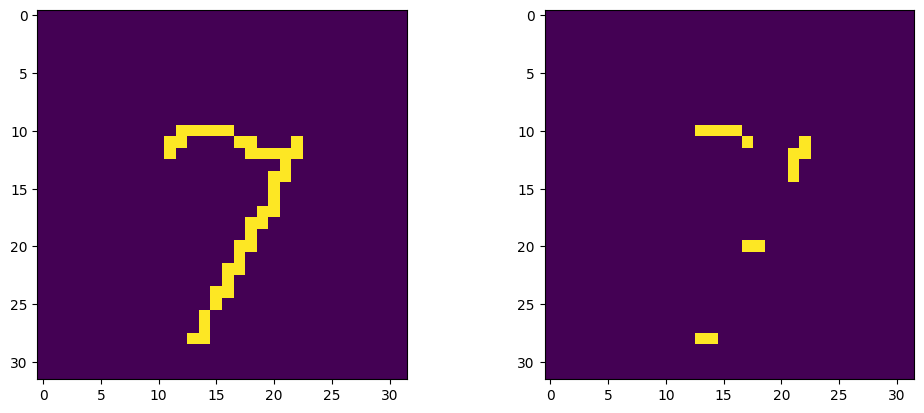

In [563]:
image_id = 773
image = next(df_train_images.loc[[image_id]].itertuples())
matchee = create_matchee(image)
seq_reading = get_sequences_reading(matchee.sequences, matchee.seq_reading_codes[0])
seq_ipxy = calc_seq_ipxy(seq_reading, matchee.si_ind_dict)
seq_bv = calc_seq_bv(seq_ipxy)
# seq_bv = (-0.5 + seq_bv)

# 1)
# seq_bv2 = calc_seq_bv(seq_ipxy + np.array([10, -30]))

# 2)
# seq_bv2 = np.roll(seq_bv.reshape(32, -1), 8, axis=1)
# seq_bv2 = np.roll(seq_bv2.reshape(32, -1), -8, axis=0)
# seq_bv2 = seq_bv2.ravel()

# 3)
# move_to_ooc_transf = np.array([
#     [1, 0, -config.sample_size / 2],
#     [0, 1, -config.sample_size / 2],
#     [0, 0, 1]])
# theta = np.deg2rad(0)
# cos_theta = math.cos(theta)
# sin_theta = math.sin(theta)
# rotation_transf = np.array([
#     [cos_theta, -sin_theta, 0],
#     [sin_theta, cos_theta, 0],
#     [0, 0, 1]
# ])
# move_to_target_loc_transf = np.array([
#     [1, 0, config.sample_size / 2],
#     [0, 1, config.sample_size / 2],
#     [0, 0, 1]])
# transf = move_to_target_loc_transf @ rotation_transf @ move_to_ooc_transf

# transf = np.array([
#     [1.5, 0, -40],
#     [0, 1.5, -50],
#     [0, 0, 1]])

# seq_ipxy2 = np.hstack([seq_ipxy, np.ones(seq_ipxy.shape[0])[:,np.newaxis]]) # make homogeneous coords
# seq_ipxy2 = xp_array_to_gpu(transf @ seq_ipxy2.T).T[:,:2]
# seq_bv2 = calc_seq_bv(seq_ipxy2)

# 4)
seq_reading2 = thin_out_sequences(seq_reading, 0.5)
seq_ipxy2 = calc_seq_ipxy(seq_reading2, matchee.si_ind_dict)
seq_bv2 = calc_seq_bv(seq_ipxy2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(seq_bv.reshape(32, -1))
ax2.imshow(seq_bv2.reshape(32, -1))
plt.show()

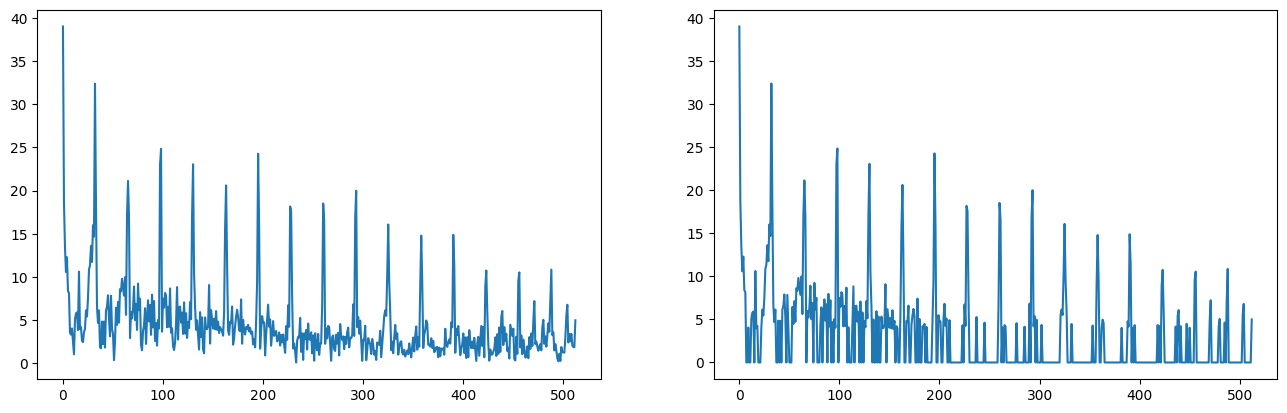

In [335]:
yf = rfft(seq_bv)
# yf_clip = np.where(np.abs(yf) > 10, yf, 0)
yf_clip = np.where(np.abs(yf) > np.max(np.abs(yf)) * 0.1, yf, 0)
xf = rfftfreq(seq_bv.shape[0], 1 / seq_bv.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
ax1.plot(xf, np.abs(yf))
ax2.plot(xf, np.abs(yf_clip))
plt.show()

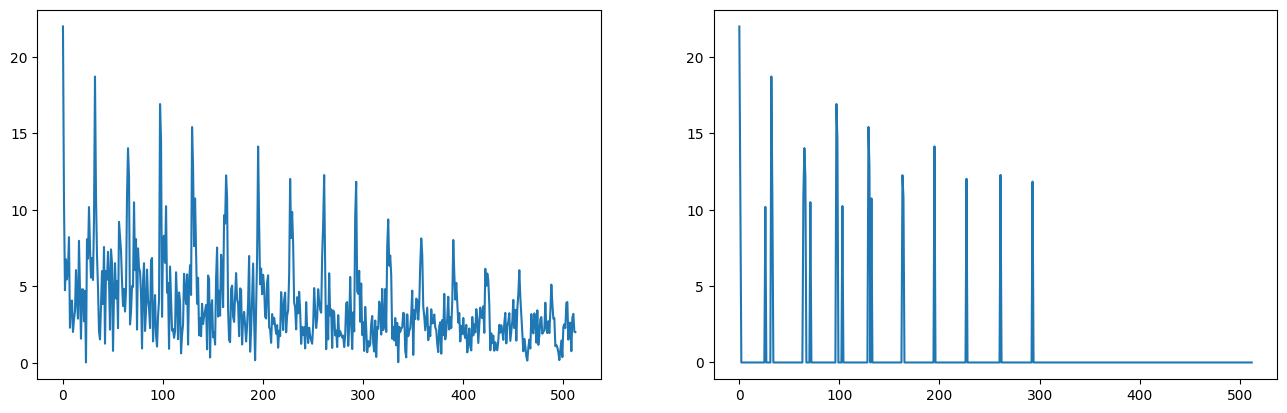

In [323]:
yf2 = rfft(seq_bv2)
yf2_clip = np.where(np.abs(yf2) > 10, yf2, 0)
xf = rfftfreq(seq_bv.shape[0], 1 / seq_bv.shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
ax1.plot(xf, np.abs(yf2))
ax2.plot(xf, np.abs(yf2_clip))
plt.show()

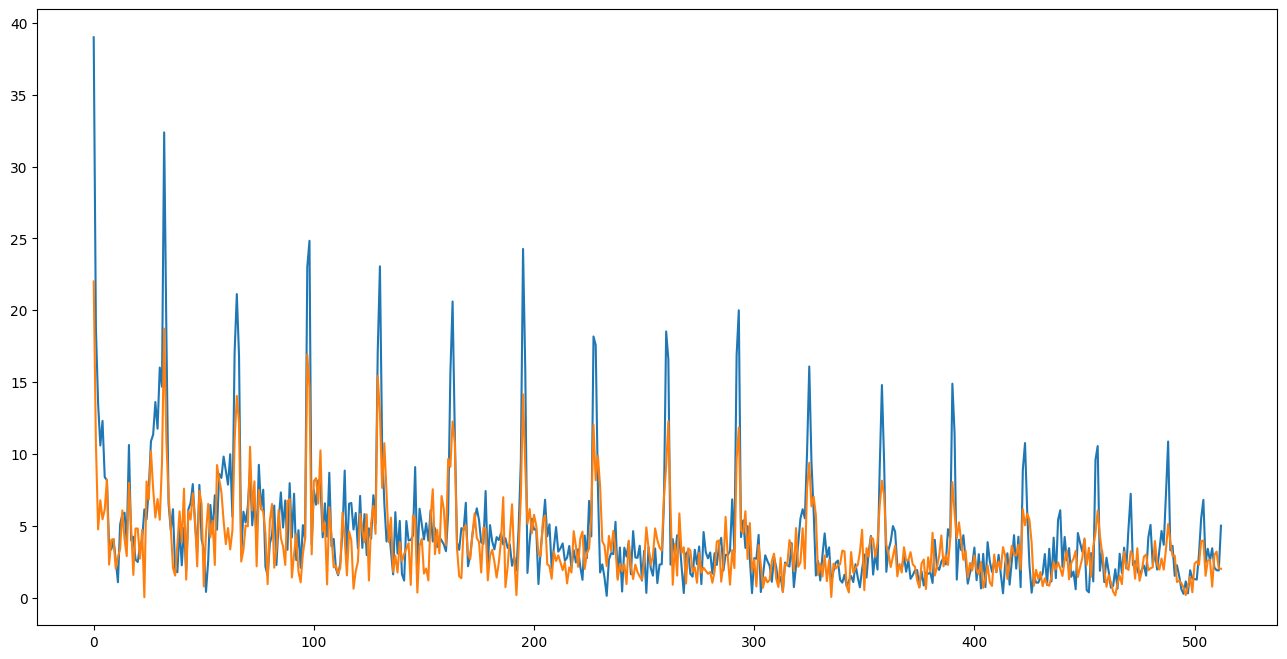

In [324]:
plt.figure(figsize=(16, 8))
plt.plot(xf, np.abs(yf))
plt.plot(xf, np.abs(yf2))
plt.show()

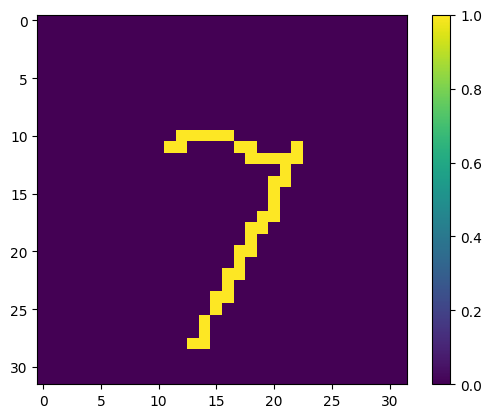

In [397]:
# yf_clip = np.where(np.abs(yf) > np.max(np.abs(yf)) * 0.2, yf, 0)
yf_clip = yf.copy()
yf_clip[270:] = 0
xf_hat = irfft(yf_clip)
xf_hat = np.where(xf_hat > 0.5, 1, 0)
plt.imshow(xf_hat.reshape(32, -1))
plt.colorbar()
plt.show()

In [409]:
list(map(lambda i: (i.Index, i.value), df_train_images.loc[RNG.choice(df_train_images.index, 10)].itertuples()))

[(3579, '7'),
 (5171, '2'),
 (37435, '2'),
 (5285, '0'),
 (34975, '9'),
 (32698, '5'),
 (56431, '9'),
 (6162, '9'),
 (5682, '6'),
 (34590, '1')]

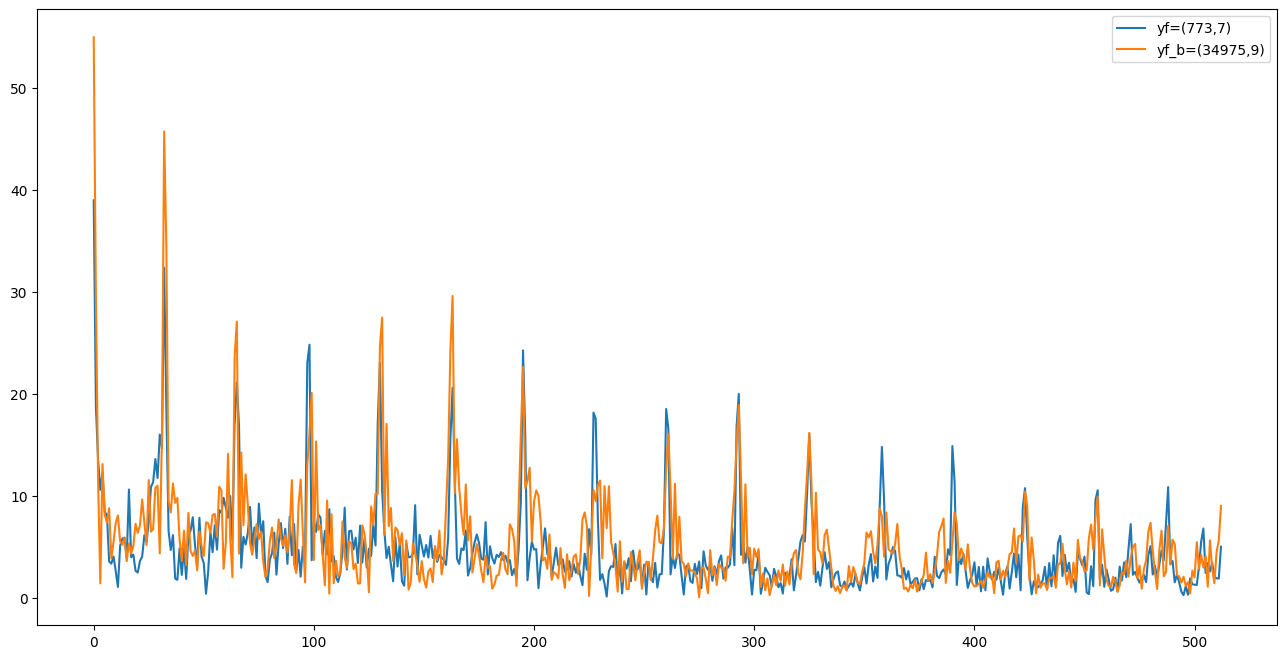

In [428]:
image_id_b = 34975
image_b = next(df_train_images.loc[[image_id_b]].itertuples())
matchee_b = create_matchee(image_b)
seq_reading_b = get_sequences_reading(matchee_b.sequences, matchee_b.seq_reading_codes[0])
seq_ipxy_b = calc_seq_ipxy(seq_reading_b, matchee_b.si_ind_dict)
seq_bv_b = calc_seq_bv(seq_ipxy_b)
yf_b = rfft(seq_bv_b)

plt.figure(figsize=(16, 8))
plt.plot(xf, np.abs(yf), label=f'yf=({image.Index},{image.value})')
plt.plot(xf, np.abs(yf_b), label=f'yf_b=({image_b.Index},{image_b.value})')
plt.legend()
plt.show()

# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_figwidth(16)
# ax1.plot(xf, np.abs(yf_b))
# ax2.plot(xf, np.abs(yf))
# plt.show()

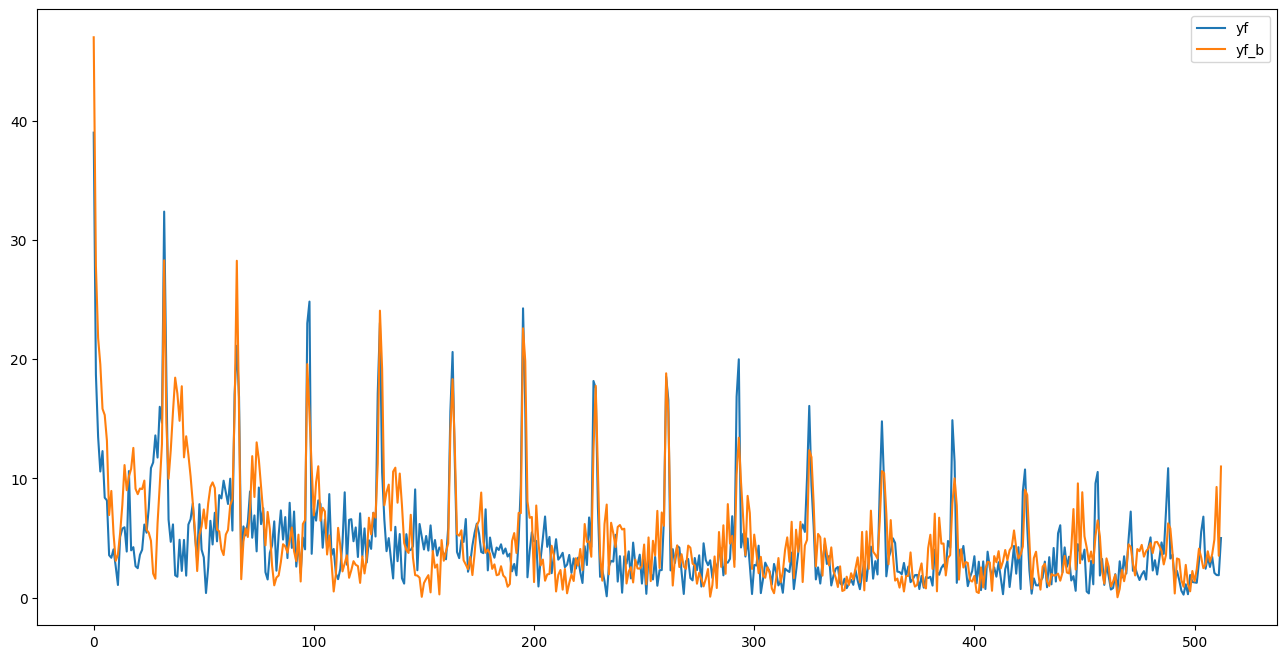

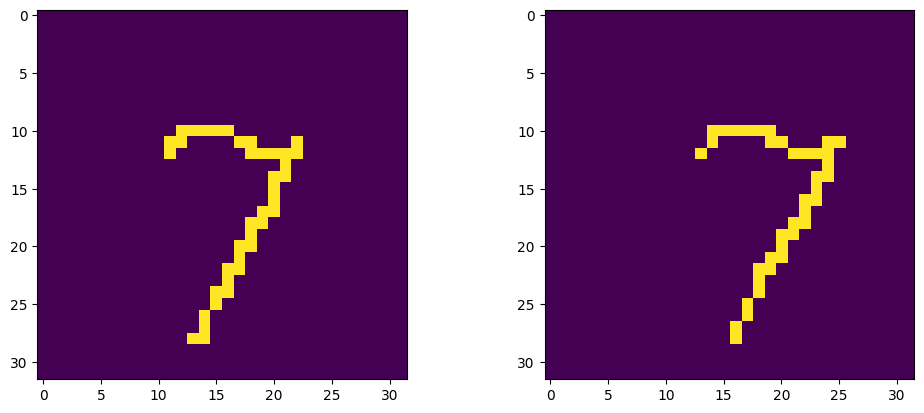

In [567]:
image_id = 773
image = next(df_train_images.loc[[image_id]].itertuples())
matchee = create_matchee(image)
seq_reading = get_sequences_reading(matchee.sequences, matchee.seq_reading_codes[0])
seq_ipxy = calc_seq_ipxy(seq_reading, matchee.si_ind_dict)
seq_bv = calc_seq_bv(seq_ipxy)

# move_to_ooc_transf = np.array([
#     [1, 0, -config.sample_size / 2],
#     [0, 1, -config.sample_size / 2],
#     [0, 0, 1]])
# theta = np.deg2rad(0)
# cos_theta = math.cos(theta)
# sin_theta = math.sin(theta)
# rotation_transf = np.array([
#     [cos_theta, -sin_theta, 0],
#     [sin_theta, cos_theta, 0],
#     [0, 0, 1]
# ])
# move_to_target_loc_transf = np.array([
#     [1, 0, config.sample_size / 2],
#     [0, 1, config.sample_size / 2],
#     [0, 0, 1]])
# transf = move_to_target_loc_transf @ rotation_transf @ move_to_ooc_transf

transf = np.array([
    [1, 0, 10],
    [0, 1, 0],
    [0, 0, 1]])

seq_ipxy2 = np.hstack([seq_ipxy, np.ones(seq_ipxy.shape[0])[:,np.newaxis]]) # make homogeneous coords
seq_ipxy2 = (transf @ seq_ipxy2.T).T[:,:2]
# seq_ipxy2 = seq_ipxy2 - seq_ipxy2[0] + seq_ipxy[0]
seq_bv2 = calc_seq_bv(seq_ipxy2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(seq_bv.reshape(32, -1))
ax2.imshow(seq_bv2.reshape(32, -1))
plt.show()

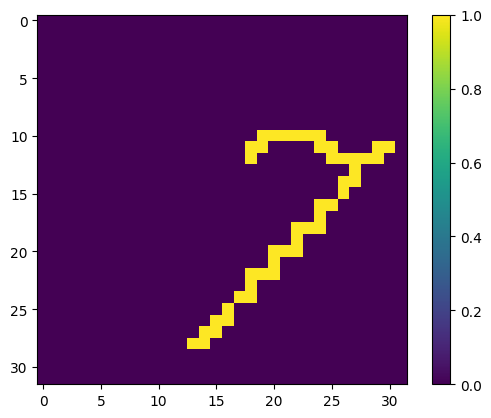

In [491]:
f1 = rfft(seq_bv)
f2 = rfft(seq_bv2)
m = f2 / f1

seq_bv2 = irfft(f1 * m)
plt.imshow(seq_bv2.reshape(32, -1))
plt.colorbar()
plt.show()

In [504]:
list(map(lambda s: s.image_id, filter(lambda s: s.value == '5', SIGNALS.values())))[:10]

[58419, 9607, 34242, 23736, 45826, 54302, 16931, 27263, 33081, 49424]

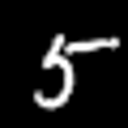

In [505]:
get_raw_image(58419)

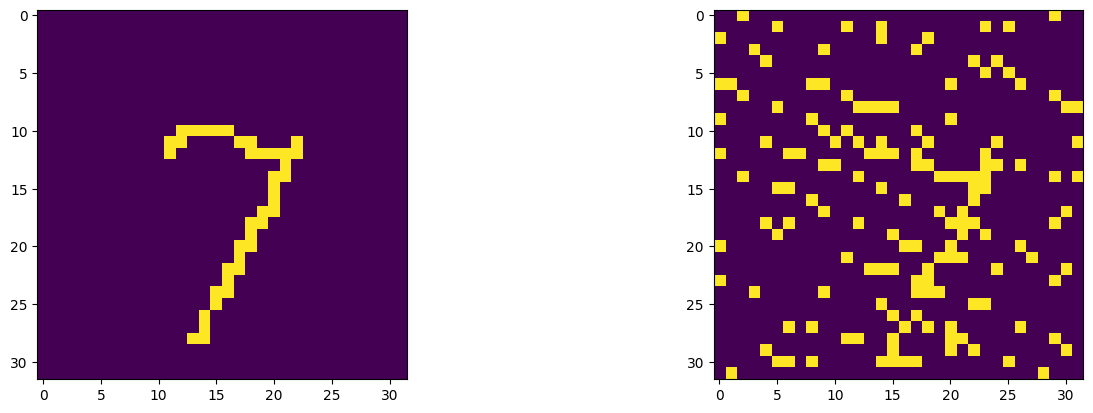

In [614]:
image_id_b = 773
image_b = next(df_train_images.loc[[image_id_b]].itertuples())
matchee_b = create_matchee(image_b)
seq_reading_b = get_sequences_reading(matchee_b.sequences, matchee_b.seq_reading_codes[0])
seq_ipxy_b = calc_seq_ipxy(seq_reading_b, matchee_b.si_ind_dict)
seq_bv_b = calc_seq_bv(seq_ipxy_b)

seq_bv_b2 = irfft(rfft(seq_bv_b) * m)
seq_bv_b2 = np.where(seq_bv_b2 > 0.5, 1, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)
ax1.imshow(seq_bv_b.reshape(32, -1))
ax2.imshow(seq_bv_b2.reshape(32, -1))
plt.show()

In [613]:
f1_list = []
f2_list = []
c = 100

for image in tqdm(df_train_images.loc[RNG.choice(df_train_images.index, c)].itertuples(), total=c):
    matchee = create_matchee(image)
    seq_reading = get_sequences_reading(matchee.sequences, matchee.seq_reading_codes[0])
    seq_ipxy = calc_seq_ipxy(seq_reading, matchee.si_ind_dict)
    seq_bv = calc_seq_bv(seq_ipxy)
    # shear
    # transf = np.array([
    #     [1, -0.4, 0],
    #     [0, 1, 0],
    #     [0, 0, 1]])
    
    # offset (translate)
    # transf = np.array([
    #     [1, 0, 10],
    #     [0, 1, 0],
    #     [0, 0, 1]])

    # rotate
    # move_to_ooc_transf = np.array([
    #     [1, 0, -config.sample_size / 2],
    #     [0, 1, -config.sample_size / 2],
    #     [0, 0, 1]])
    # theta = np.deg2rad(15)
    # cos_theta = math.cos(theta)
    # sin_theta = math.sin(theta)
    # rotation_transf = np.array([
    #     [cos_theta, -sin_theta, 0],
    #     [sin_theta, cos_theta, 0],
    #     [0, 0, 1]
    # ])
    # move_to_target_loc_transf = np.array([
    #     [1, 0, config.sample_size / 2],
    #     [0, 1, config.sample_size / 2],
    #     [0, 0, 1]])
    # transf = move_to_target_loc_transf @ rotation_transf @ move_to_ooc_transf

    # scale
    transf = np.array([
        [1.1, 0, 0],
        [0, 1.1, 0],
        [0, 0, 1]])
    
    seq_ipxy2 = np.hstack([seq_ipxy, np.ones(seq_ipxy.shape[0])[:,np.newaxis]]) # make homogeneous coords
    seq_ipxy2 = (transf @ seq_ipxy2.T).T[:,:2]
    # seq_ipxy2 = seq_ipxy2 - seq_ipxy2[0] + seq_ipxy[0]
    seq_bv2 = calc_seq_bv(seq_ipxy2)
    f1_list.append(rfft(seq_bv))
    f2_list.append(rfft(seq_bv2))

f1_list = np.array(f1_list)
f2_list = np.array(f2_list)
f1_sum = f1_list.sum(axis=0)
f2_sum = f2_list.sum(axis=0)
m = np.where(f1_sum == 0, 0, f2_sum / (f1_sum + 1e-20))

  0%|          | 0/100 [00:00<?, ?it/s]

In [610]:
f1_list = np.array(f1_list)
f2_list = np.array(f2_list)
f1_sum = f1_list.sum(axis=0)
f2_sum = f2_list.sum(axis=0)
m = np.where(f1_sum == 0, 0, f2_sum / (f1_sum + 1e-20))

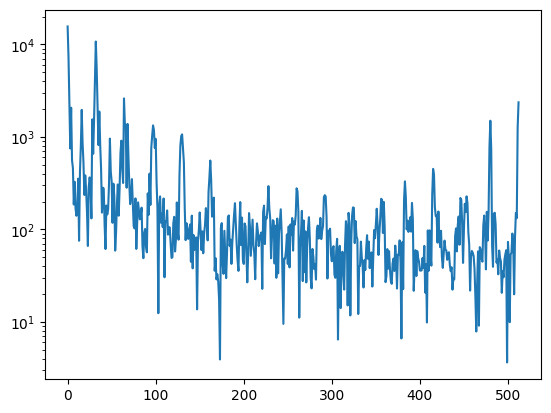

In [571]:
plt.semilogy(rfftfreq(seq_bv.shape[0], 1 / seq_bv.shape[0]), np.abs(f1_sum));

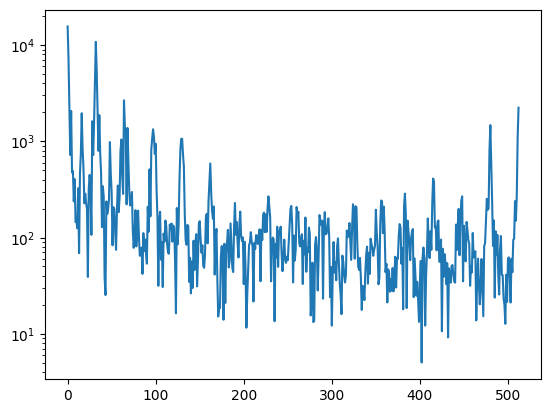

In [572]:
plt.semilogy(rfftfreq(seq_bv.shape[0], 1 / seq_bv.shape[0]), np.abs(f2_sum));

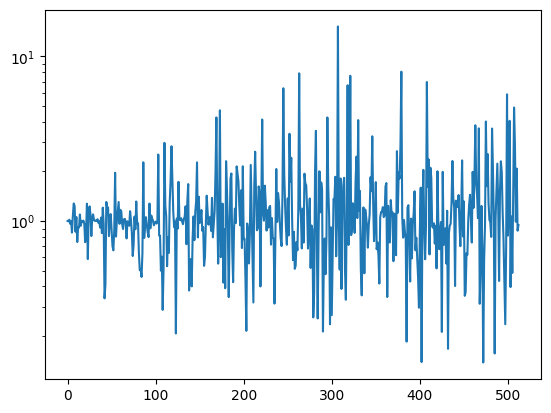

In [573]:
plt.semilogy(rfftfreq(seq_bv.shape[0], 1 / seq_bv.shape[0]), np.abs(m));

In [559]:
np.argmax(np.abs(m))

np.int64(411)

In [560]:
f1_sum[411], f2_sum[411]

(np.complex64(-0.4647087+1.1175586j), np.complex64(88.77018+11.811329j))

# Train

In [25]:
LOG.is_enabled = True

In [26]:
train_images_count = min(1000, len(df_train_images))
max_learn_signals_count = 999999

In [27]:
TRAIN_RUNS_COUNT = 0
TRAIN_UNIQUE_IMAGE_IDS = set()
# clear_memory(with_caches=False)
clear_memory(with_caches=True)

In [28]:
# %%time
train_runs = 10

for train_run in tqdm(range(train_runs), desc='Train run'):
    with LOG.auto_prefix('TRRUN', train_run):
        TRAIN_RUNS_COUNT += 1
        
        train_image_ids = RNG.choice(df_train_images.index.unique(), train_images_count, replace=False)
        # train_image_ids = [52523]
        df_train_run_images = df_train_images.loc[train_image_ids]
        signals_by_state = Counter(map(lambda s: s.state.name, SIGNALS.values()))
        LOG(f'Signals 1): {signals_by_state}')
    
        ###
        for image in tqdm(df_train_run_images.itertuples(), total=len(df_train_run_images), leave=False, desc='Images'):
            image_id = int(image.Index)
            image_value = image.value
            TRAIN_UNIQUE_IMAGE_IDS.add(image_id)
            
            with LOG.auto_prefix('IMGID', image_id, 'VAL', image_value):
                # matchee = create_matchee_cached(image)
                matchee = create_matchee(image)
        
                inspect_depth = 100
                cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
                top_mat_indices = xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:]
                cos_sims = xp.take(cos_sim_mat, top_mat_indices)
                top_mat_indices = xp_array_from_gpu(xp.flip(top_mat_indices))
                cos_sims = xp_array_from_gpu(xp.flip(cos_sims))
        
                is_learn_signal_exists = False
                matches = Counter()
                votes = {}
        
                for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
                    if cos_sim < HP_SEQ_LV_COS_SIM_THRESHOLD:
                        break
                    
                    seq_lv_ind = top_mat_index // cos_sim_mat.shape[1]
                    signal = SIGNALS[seq_lv_ind]
                    matchee_seq_lv_ind = top_mat_index % cos_sim_mat.shape[1]
                    matchee_seq_reading_code = matchee.seq_reading_codes[matchee_seq_lv_ind]
                    matchee_seq_reading = get_sequences_reading(matchee.sequences, matchee_seq_reading_code)
                    observation = SignalObservation(image_id=image_id, 
                                                    cos_sim=cos_sim,
                                                    value=image_value,
                                                    is_correct_match=(signal.value == image_value),
                                                    seq_reading_code=matchee_seq_reading_code,
                                                    seq_reading=matchee_seq_reading,
                                                    si_ind_dict=matchee.si_ind_dict)
                    signal.observations[image_id] = observation
                    signal.flags[SignalFlag.IS_NEW_OBSERVATION] = 1

                    if signal.state == SignalState.LEARN:
                        is_learn_signal_exists = True
                        continue

                    assert signal.state == SignalState.PROD, signal.state
                    matchee_seq_xy = get_xy_sequence(get_sequence(matchee_seq_reading), matchee.si_ind_dict)
                    matchee_seq_bv = calc_seq_bv(matchee_seq_xy)
                    cpav = get_cs_point_activations_vec(matchee_seq_bv)
                    pcs_activation_vec = (cpav @ signal.pcs.T)
                    pcs_activation_vec = (pcs_activation_vec >= signal.pc_ones_counts).astype('f')
                    is_match = np.any(pcs_activation_vec) # is any of PC is activated?
        
                    if is_match and not signal.seq_lv_ind in votes:
                        signal.flags[[SignalFlag.FALSE_POSITIVES_CTR, SignalFlag.TRUE_POSITIVES_CTR][signal.value == image_value]] += 1
                        votes[signal.seq_lv_ind] = signal.value
                        matches[signal.value] += 1
                        LOG(f'Prod signal seq_lv_ind={signal.seq_lv_ind} matched, value={signal.value}')

                if matches:
                    most_voted_value = matches.most_common(1)[0][0]
                    is_correct_match = (most_voted_value == image_value)
                    LOG(f'Matches: {matches}, most voted={most_voted_value}, is_correct_match={is_correct_match}')
                else:
                    is_correct_match = False
                    
                is_surprise = not is_learn_signal_exists and not is_correct_match
                learn_signals_count = signals_by_state[SignalState.LEARN.name]
                LOG(f'is_surprise={is_surprise}, is_learn_signal_exists={is_learn_signal_exists}, is_correct_match={is_correct_match}, learn_signals_count={learn_signals_count}')
        
                if is_surprise and learn_signals_count < max_learn_signals_count:
                    signal = memorize_signal(image)
                    signals_by_state[SignalState.LEARN.name] += 1
                    LOG(f'New learn signal seq_lv_ind={signal.seq_lv_ind}. Learn signals {signals_by_state[SignalState.LEARN.name]} / {max_learn_signals_count}')
    
        ###
        signals_by_state = Counter(map(lambda s: s.state.name, SIGNALS.values()))
        LOG(f'Signals 2): {signals_by_state}')
        
        for signal in tqdm(SIGNALS.values(), leave=False, desc='Signals'):
            with LOG.auto_prefix('SIG', signal.seq_lv_ind, 'STATE', signal.state.name):
                if signal.state == SignalState.LEARN:
                    LOG(f'Signal has {len(signal.observations)} observations, thres={HP_SIGNAL_LEARN_OBSERVATIONS_COUNT_TRHES}')
                    
                    if len(signal.observations) < HP_SIGNAL_LEARN_OBSERVATIONS_COUNT_TRHES:
                       continue

                    signal = learn_signal_pcs(signal)
                    new_state = SignalState.PROD if signal.pcs.shape[0] > 0 else SignalState.DEAD
                    SIGNALS[signal.seq_lv_ind] = signal._replace(state=new_state)
                    LOG(f'PCs learned, {signal.pcs.shape[0]} PCs, state={new_state.name}')
                elif signal.state == SignalState.PROD:
                    if SignalFlag.IS_NEW_OBSERVATION in signal.flags:
                        signal = learn_signal_pcs(signal)
                        new_state = SignalState.PROD if signal.pcs.shape[0] > 0 else SignalState.DEAD
                        SIGNALS[signal.seq_lv_ind] = signal._replace(state=new_state)
                        LOG(f'PCs relearned, {signal.pcs.shape[0]} PCs, state={new_state.name}')

                    signal.flags.clear()
                else:
                    assert False, (signal.seq_lv_ind, signal.state.name)

        signals_by_state = Counter(map(lambda s: s.state.name, SIGNALS.values()))
        LOG(f'Signals 3): {signals_by_state}')

        dead_signal_seq_lv_inds = list(map(lambda s: s.seq_lv_ind, filter(lambda s: s.state == SignalState.DEAD, SIGNALS.values())))

        for seq_lv_ind in dead_signal_seq_lv_inds:
            del SIGNALS[seq_lv_ind]
            SEQ_LVS.release(seq_lv_ind)
            LOG(f'Signal seq_lv_ind={seq_lv_ind} forgotten')

Train run:   0%|          | 0/10 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/236 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/462 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/630 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/791 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/923 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/1052 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/1131 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/1221 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/1295 [00:00<?, ?it/s]

Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Signals:   0%|          | 0/1347 [00:00<?, ?it/s]

In [657]:
c = Counter(list(map(lambda s: len(s.observations) // 10, SIGNALS.values())))
c

Counter({0: 536,
         1: 231,
         2: 107,
         3: 97,
         4: 51,
         5: 38,
         7: 32,
         6: 29,
         8: 27,
         9: 17,
         12: 16,
         10: 15,
         11: 14,
         14: 12,
         16: 9,
         13: 8,
         22: 4,
         15: 4,
         20: 3,
         28: 3,
         27: 2,
         19: 2,
         18: 2,
         26: 2,
         21: 2,
         23: 2,
         24: 1,
         17: 1,
         33: 1,
         31: 1,
         29: 1,
         55: 1,
         30: 1,
         37: 1,
         25: 1})

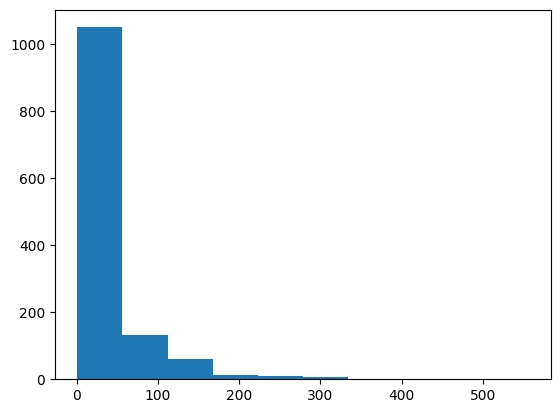

In [653]:
plt.hist(list(map(lambda s: len(s.observations), SIGNALS.values())))
plt.show()

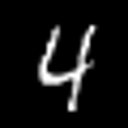

In [119]:
seq_lv_ind = 1
signal = SIGNALS[seq_lv_ind]
get_raw_image(signal.image_id)

In [120]:
len(signal.pc_sets)

39

cs_cluster_inds=[1 8], pc_set_ones_count=98, obs=Counter({True: 162, False: 16})


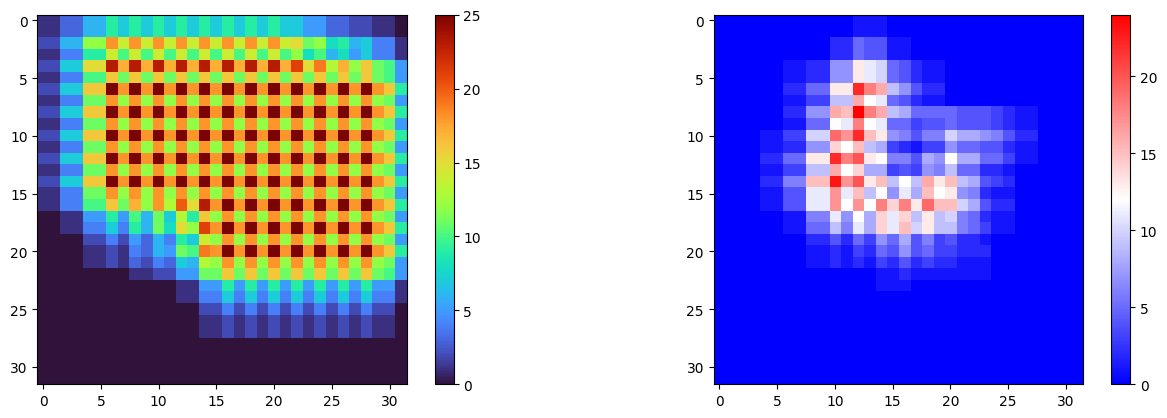

In [121]:
pc_set_ind = 4
cs_cluster_inds = signal.pc_set_ind_to_cs_cluster_inds[pc_set_ind]
obs_counter = Counter(map(lambda ob: ob.is_correct_match, signal.observations.values()))
print(f'cs_cluster_inds={cs_cluster_inds}, pc_set_ones_count={signal.pc_set_ones_counts[pc_set_ind]:.0f}, obs={obs_counter}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

map1 = (CS_POINTS.T * np.max(CS_CLUSTERS[cs_cluster_inds], axis=0)).T.sum(axis=0)
im = ax1.imshow(map1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

map2 = (CS_POINTS.T * signal.pc_sets[pc_set_ind]).T.sum(axis=0)
im = ax2.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.show()

## .lab

In [139]:
signal = SIGNALS[371]

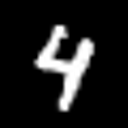

In [140]:
get_raw_image(signal.image_id)

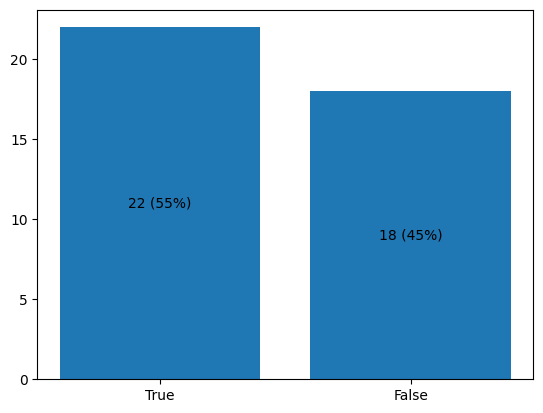

In [141]:
pos_neg = Counter(map(lambda ob: ob.is_correct_match, signal.observations.values()))
b = plt.bar(list(map(str, pos_neg.keys())), list(pos_neg.values()))
plt.bar_label(b, map(lambda v: f'{v} ({100 * v / len(signal.observations):.0f}%)', pos_neg.values()), label_type='center')
plt.show()

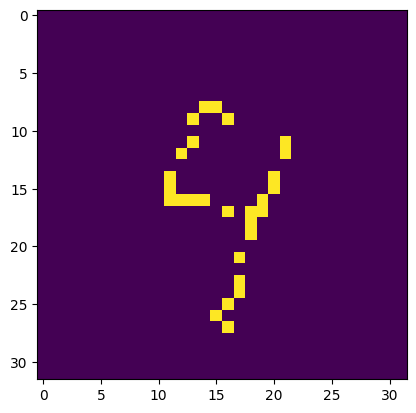

In [142]:
seq_xy = get_xy_sequence(get_sequence(signal.seq_reading), signal.si_ind_dict)
center_xy = np.mean((seq_xy - seq_xy[0]), axis=0)
origin_offset = -center_xy + np.full(2, config.sample_size / 2) # offset to move figure's center to center of future bitmap

bitmap_vec = calc_seq_bv(seq_xy, origin_offset)
plt.imshow(bitmap_vec.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.show()

In [143]:
correct_obs = list(filter(lambda hi: hi.is_correct_match, signal.observations.values()))

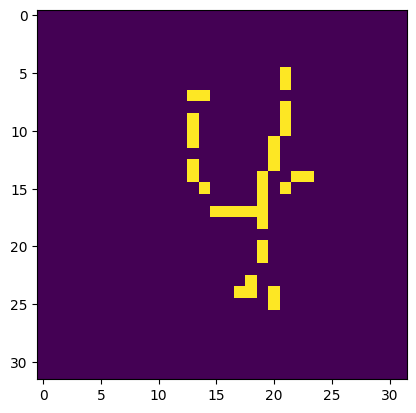

In [223]:
ob_ind = RNG.choice(len(correct_obs))
ob = correct_obs[ob_ind]
ob_seq_xy = get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict)
ob_seq_bv = calc_seq_bv(ob_seq_xy, origin_offset)
plt.imshow(ob_seq_bv.reshape(HP_COMBI_SPACE_SIZE, -1))
plt.show()

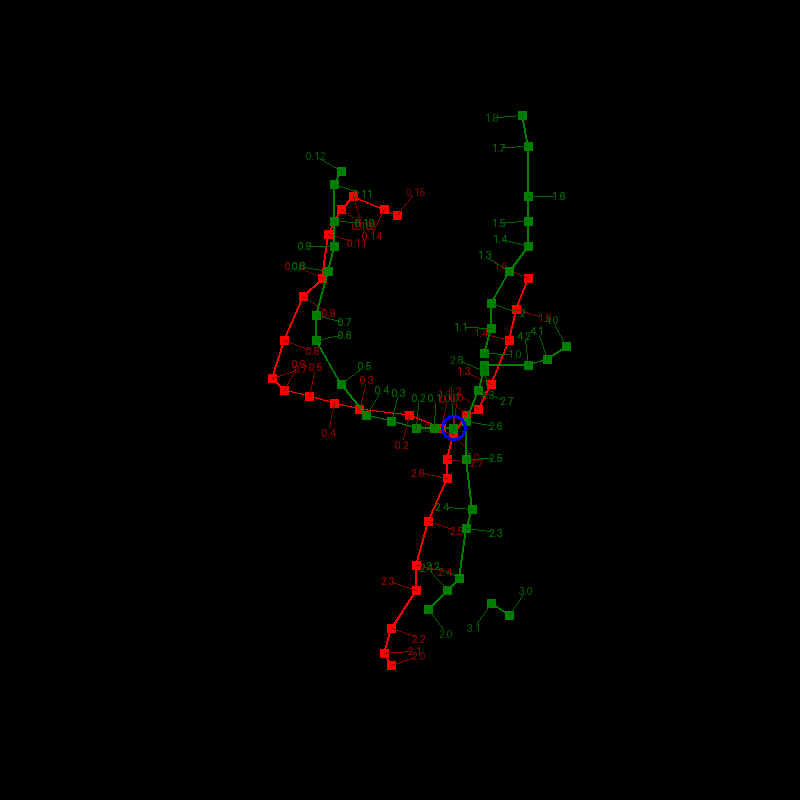

In [224]:
canvas = render_seq_reading(signal.seq_reading, signal.si_ind_dict, origin_offset=origin_offset)
render_seq_reading(ob.seq_reading, ob.si_ind_dict, origin_offset=origin_offset, canvas=canvas, palette={'all': 'green', 'normal': 'darkgreen', 'start': 'blue'})

In [179]:
hist_to_take = 1
correct_obs = list(filter(lambda hi: hi.is_correct_match, signal.observations.values()))[:hist_to_take]

In [180]:
pcs_incubator = CS_CLUSTERS.copy()

In [181]:
# %%time
ob_seq_bvs = []
# z = (seq_pc_matur.seq_pc > 0).sum()
# nu = 1 / z
# print(z, nu)
# mask = (seq_pc > 0).astype('f')

# # nu = 0.0001

for ob in correct_obs:
    ob_seq_xy = get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict)
    ob_seq_bv = calc_seq_bv(ob_seq_xy, origin_offset)
    ob_seq_bvs.append(ob_seq_bv)
    
    cpav = get_cs_point_activations_vec(ob_seq_bv)
    ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
    grow = (cpav * (CS_CLUSTER_NUS * ys)[:,np.newaxis]) # how weights of each PC must grow up, matrix, ca. shape (35, 675)
    grow *= CS_CLUSTERS # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
    nomins = pcs_incubator + grow # grow weights of incubated PCs
    denoms = nomins.max(axis=1) 
    pcs_incubator = (nomins.T / denoms).T # redistribute weights

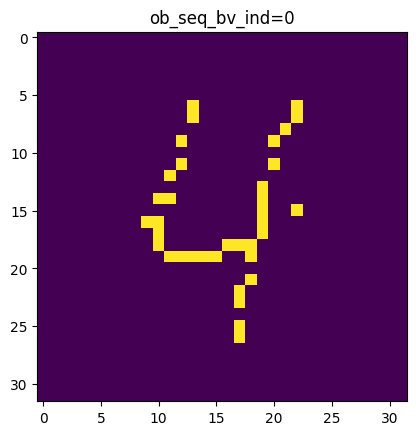

In [182]:
ob_seq_bv_ind = RNG.choice(len(ob_seq_bvs))
plt.imshow(ob_seq_bvs[ob_seq_bv_ind].reshape(HP_COMBI_SPACE_SIZE, -1))
plt.title(f'ob_seq_bv_ind={ob_seq_bv_ind}')
plt.show()

In [183]:
pcs = np.where(pcs_incubator > 0.75, 1, 0)
pc_ones_counts = pcs.sum(axis=1)

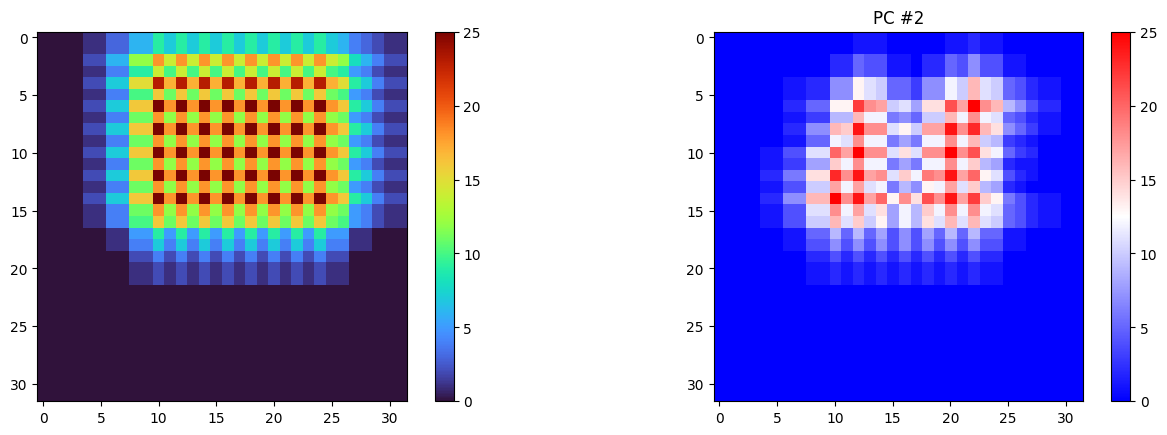

In [184]:
pc_ind = RNG.choice(pcs.shape[0])
# pc_ind = 6

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

cps1 = (CS_POINTS.T * CS_CLUSTERS[pc_ind]).T.sum(axis=0)
im = ax1.imshow(cps1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

cps2 = (CS_POINTS.T * pcs[pc_ind]).T.sum(axis=0)
im = ax2.imshow(cps2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.title(f'PC #{pc_ind}')
plt.show()

In [185]:
# correct_matches_flt = list(filter(lambda ob: ob.is_correct_match, signal.observations.values()))
# correct_matches_cnt = len(correct_matches_flt)
correct_matches_flt = correct_obs
correct_matches_cnt = len(correct_obs)

correct_matches_seq_xy = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), correct_matches_flt)
correct_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), correct_matches_seq_xy))
correct_bvs = np.vstack(correct_bvs)
correct_cpavs = ((correct_bvs @ CS_POINTS.T) > 0).astype('f')
correct_pc_activations_mat = (correct_cpavs @ pcs.T)
correct_pc_activations_mat2 = (correct_pc_activations_mat >= pc_ones_counts).astype(int)
correct_pc_activations_vec = correct_pc_activations_mat2.sum(axis=0)
t = correct_pc_activations_vec
(t >= correct_matches_cnt).sum(), t, np.flip(np.sort(t)[-HP_SIGNAL_PCS_COUNT:])

(np.int64(28),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1]))

In [191]:
# seq_xy -> seq_bv -> cpav -> pcs -> pc_sets
top_active_pc_inds = xp.flip(xp.argsort(correct_pc_activations_vec)[-HP_SIGNAL_PCS_COUNT:])
top_active_pc_inds = xp_array_from_gpu(top_active_pc_inds)

pc_ind_combos = list(itertools.product([0, 1], repeat=HP_SIGNAL_PCS_COUNT)) # various combos in form of [0, 0, 1, 1, 0, 1]
pc_ind_combos = np.array(pc_ind_combos[1:]) # take all combos except first degenerate one (it contains all zeros)
pc_set_pc_inds_mat = np.where(pc_ind_combos, top_active_pc_inds, -1) # turn combo items 0/1 to corresponding indices of PCs e.g. [-1, -1, 17, 2, -1, 9]
pc_sets = [] # PC_SET is a union of some other PCs
pc_set_ind_to_cs_cluster_inds = [] # inds of CS_CLUSTERS which constitute given PC_SET

for pc_set_pc_inds in pc_set_pc_inds_mat:
    pc_set_pc_inds = pc_set_pc_inds[pc_set_pc_inds > -1]
    pc_set = np.max(pcs[pc_set_pc_inds], axis=0)
    assert np.array_equal(np.unique(pc_set), [0, 1])
    pc_sets.append(pc_set)
    pc_set_ind_to_cs_cluster_inds.append(pc_set_pc_inds)

pc_sets = xp.vstack(pc_sets)
pc_set_ones_counts = pc_sets.sum(axis=1).astype('f')
pc_sets.shape

# pc_ind_combos = np.array(list(itertools.product([0, 1], repeat=HP_SIGNAL_PCS_COUNT))) # various combos in form of [0, 0, 1, 1, 0, 1]
# pc_set_inds_mat = np.where(pc_ind_combos, top_active_pc_inds, -1) # turn combo items 0/1 to indices e.g. [-1, -1, 3, 15, -1, 27]
# pc_set_masks = []

# for pc_set_inds in pc_set_inds_mat:
#     pc_set_inds = pc_set_inds[pc_set_inds > -1]
#     pc_set_mask = np.zeros(CS_CLUSTERS.shape[0], dtype='f')
#     pc_set_mask[pc_set_inds] = 1
#     pc_set_masks.append(pc_set_mask)

# pc_set_masks = xp.vstack(pc_set_masks)
# pc_set_masks.shape

(63, 675)

In [187]:
confusion_matrix = np.zeros((pc_sets.shape[0], 2), dtype='f')
ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.observations.values())
ob_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), ob_seq_xys))
ob_bvs = np.vstack(ob_bvs)
ob_cpavs = ((ob_bvs @ CS_POINTS.T) > 0).astype('f')
ob_pc_sets_activation_mat = (ob_cpavs @ pc_sets.T)
ob_pc_sets_activation_mat = (ob_pc_sets_activation_mat >= pc_set_ones_counts).astype('f')

for ob, ob_pc_sets_activation in zip(signal.observations.values(), ob_pc_sets_activation_mat):
    confusion_matrix_col_index = 1 - int(ob.is_correct_match)
    confusion_matrix[:,confusion_matrix_col_index] += ob_pc_sets_activation

# confusion_matrix = np.zeros((top_active_pc_set_masks.shape[0], 2))
# ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.learn.observations.values())
# ob_bvs = list(map(lambda seq_xy: calc_seq_bv(seq_xy, origin_offset), ob_seq_xys))
# ob_bvs = np.vstack(ob_bvs)
# ob_ccavs = ((ob_bvs @ CS_POINTS.T) > 0).astype('f')
# ob_pc_sets_activation_mat = (ob_ccavs @ pcs.T)
# ob_pc_sets_activation_mat = (ob_pc_sets_activation_mat >= pc_ones_counts).astype(int)

# for ob, ob_pc_sets_activation in zip(signal.learn.observations.values(), ob_pc_sets_activation_mat):
#     full_activation_vec = np.all((ob_pc_sets_activation * top_active_pc_set_masks) == top_active_pc_set_masks, axis=1).astype(int)
#     confusion_matrix_col_index = 1 - int(ob.is_correct_match)
#     confusion_matrix[:,confusion_matrix_col_index] += full_activation_vec

In [195]:
# confusion_matrix[:10]

In [197]:
confusion_matrix[(confusion_matrix[:,1] == 0) & (confusion_matrix[:,0] > 0)][:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [198]:
np.argwhere((confusion_matrix[:,1] == 0) & (confusion_matrix[:,0] > 0))[:10]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [205]:
list(enumerate(pc_set_ind_to_cs_cluster_inds))

[(0, array([26])),
 (1, array([28])),
 (2, array([28, 26])),
 (3, array([31])),
 (4, array([31, 26])),
 (5, array([31, 28])),
 (6, array([31, 28, 26])),
 (7, array([32])),
 (8, array([32, 26])),
 (9, array([32, 28])),
 (10, array([32, 28, 26])),
 (11, array([32, 31])),
 (12, array([32, 31, 26])),
 (13, array([32, 31, 28])),
 (14, array([32, 31, 28, 26])),
 (15, array([33])),
 (16, array([33, 26])),
 (17, array([33, 28])),
 (18, array([33, 28, 26])),
 (19, array([33, 31])),
 (20, array([33, 31, 26])),
 (21, array([33, 31, 28])),
 (22, array([33, 31, 28, 26])),
 (23, array([33, 32])),
 (24, array([33, 32, 26])),
 (25, array([33, 32, 28])),
 (26, array([33, 32, 28, 26])),
 (27, array([33, 32, 31])),
 (28, array([33, 32, 31, 26])),
 (29, array([33, 32, 31, 28])),
 (30, array([33, 32, 31, 28, 26])),
 (31, array([34])),
 (32, array([34, 26])),
 (33, array([34, 28])),
 (34, array([34, 28, 26])),
 (35, array([34, 31])),
 (36, array([34, 31, 26])),
 (37, array([34, 31, 28])),
 (38, array([34, 3

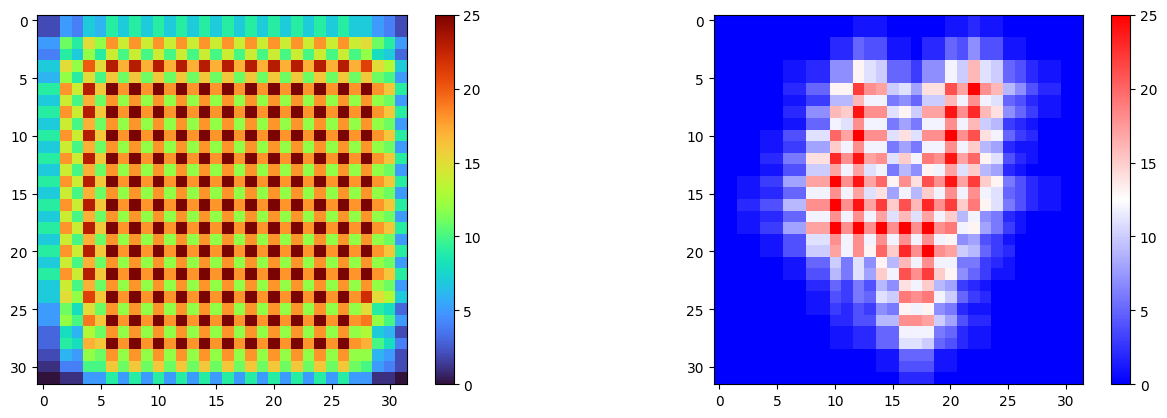

In [212]:
pc_set_ind = 62
cs_cluster_inds = pc_set_ind_to_cs_cluster_inds[pc_set_ind]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

map1 = (CS_POINTS.T * np.max(CS_CLUSTERS[cs_cluster_inds], axis=0)).T.sum(axis=0)
im = ax1.imshow(map1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

map2 = (CS_POINTS.T * pc_sets[pc_set_ind]).T.sum(axis=0)
im = ax2.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.show()

## d&c

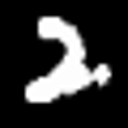

In [213]:
signal = SIGNALS[105]
get_raw_image(signal.image_id)

In [535]:
LearnSignalPcsCycleResult = namedtuple('LearnSignalPcsCycleResult', ['pc', 'pc_ones_count', 'cs_cluster_ind', 'tp_cpav_mask'])

def learn_signal_pcs_cycle(tp_cpavs, fp_cpavs):
    assert tp_cpavs.shape[0] > 0
    pcs_incubator = CS_CLUSTERS.copy()
    
    for cpav in tp_cpavs:
        ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
        grow = (cpav * (CS_CLUSTER_NUS * ys)[:,np.newaxis]) # how weights of each PC must grow up in response co cpav, matrix, ca. shape (35, 675)
        grow *= CS_CLUSTERS # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
        nomins = pcs_incubator + grow # grow weights of incubated PCs
        denoms = nomins.max(axis=1) 
        pcs_incubator = (nomins.T / denoms).T # redistribute weights
    
    pcs = xp.where(pcs_incubator > HP_SIGNAL_PC_BINARIZE_THRES, 1.0, 0.0).astype('f')
    pc_ones_counts = pcs.sum(axis=1).astype('f')
    pc_ind_to_cs_cluster_inds = np.arange(pcs.shape[0])
    
    sort_inds = xp.flip(xp.argsort(pc_ones_counts)) # sort by complexity, more complex go first
    pcs = pcs[sort_inds]
    pc_ones_counts = pc_ones_counts[sort_inds]
    pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[sort_inds]
    
    # Validate all observations (TP and FP) against PCs
    all_cpavs = xp.vstack([tp_cpavs, fp_cpavs])
    ob_pcs_activation_mat = (all_cpavs @ pcs.T)
    ob_pcs_activation_mat = (ob_pcs_activation_mat >= pc_ones_counts).astype('f') # row - observation, columns - binary vector of PCs activations for each ob
    pc_obs_activation_mat = ob_pcs_activation_mat.T # row - pc_set, columns - binary vector of obs for which given PC is activated
    
    # retain only accurate PCs: with TP and no FP
    mask_tp = xp.any(pc_obs_activation_mat[:,:tp_cpavs.shape[0]], axis=1)
    mask_fp = ~xp.any(pc_obs_activation_mat[:,tp_cpavs.shape[0]:], axis=1)
    mask = xp.argwhere(mask_tp & mask_fp).ravel()
    pcs = pcs[mask]
    pc_ones_counts = pc_ones_counts[mask]
    pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[mask]
    pc_obs_activation_mat = pc_obs_activation_mat[mask]
    
    # get PC which reacted on majority of tp_cpavs
    obs_per_pc_counts = pc_obs_activation_mat[:,:tp_cpavs.shape[0]].sum(axis=1)
    winner_pc_ind = np.argmax(obs_per_pc_counts)
    result = LearnSignalPcsCycleResult(pc=pcs[winner_pc_ind], 
                                       pc_ones_count=pc_ones_counts[winner_pc_ind],
                                       cs_cluster_ind=pc_ind_to_cs_cluster_inds[winner_pc_ind],
                                       tp_cpav_mask=pc_obs_activation_mat[winner_pc_ind,:tp_cpavs.shape[0]].astype(bool))
    return result

In [569]:
LearnSignalPcs2Result = namedtuple('LearnSignalPcs2Result', ['pcs', 'pc_ones_counts', 'pc_ind_to_cs_cluster_inds'])

def learn_signal_pcs2(signal):
    ob_tps = np.array(list(map(lambda ob: ob.is_correct_match, signal.observations.values()))) # true positives
    ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.observations.values())
    ob_seq_bvs = map(lambda ob_seq_xy: calc_seq_bv(ob_seq_xy, signal.origin_offset), ob_seq_xys)
    ob_seq_bvs = xp.vstack(list(ob_seq_bvs))
    ob_cpavs = ((ob_seq_bvs @ CS_POINTS.T) > 0).astype('f') # how each seq_bv activated CP_POINTS, ca. shape (50, 675)

    ob_tp_cpavs = ob_cpavs[ob_tps]
    ob_fp_cpavs = ob_cpavs[~ob_tps]

    pcs, pc_ones_counts, pc_ind_to_cs_cluster_inds = [], [], []

    while ob_tp_cpavs.shape[0] > 0:
        cycle_result = learn_signal_pcs_cycle(ob_tp_cpavs, ob_fp_cpavs)
        pcs.append(cycle_result.pc)
        pc_ones_counts.append(cycle_result.pc_ones_count)
        pc_ind_to_cs_cluster_inds.append(cycle_result.cs_cluster_ind)
        ob_tp_cpavs = ob_tp_cpavs[~cycle_result.tp_cpav_mask] # exclude from ob_tp_cpavs samples which are governed by returned PC

    return LearnSignalPcs2Result(pcs=xp.vstack(pcs), pc_ones_counts=xp.hstack(pc_ones_counts), pc_ind_to_cs_cluster_inds=pc_ind_to_cs_cluster_inds)

In [625]:
r = learn_signal_pcs2(signal)

obs = list(signal.observations.values())
ob_tps = np.array(list(map(lambda ob: ob.is_correct_match, obs))) # true positives
ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), obs)
ob_seq_bvs = map(lambda ob_seq_xy: calc_seq_bv(ob_seq_xy, signal.origin_offset), ob_seq_xys)
ob_seq_bvs = xp.vstack(list(ob_seq_bvs))
ob_cpavs = ((ob_seq_bvs @ CS_POINTS.T) > 0).astype('f') # how each seq_bv activated CP_POINTS, ca. shape (50, 675)

ob_pcs_activation_mat = (ob_cpavs @ r.pcs.T)
ob_pcs_activation_mat = (ob_pcs_activation_mat >= r.pc_ones_counts).astype('f') 
pc_obs_activation_mat = ob_pcs_activation_mat.T

images = []
captions = []
col_count = 8

for pc_ind, pc_obs_activation_vec in enumerate(pc_obs_activation_mat):
    ob_inds = np.argwhere(pc_obs_activation_vec).ravel() # indices of obs for which this PC is triggered
    ob_images = list(map(lambda ob_ind: get_raw_image(obs[ob_ind].image_id), ob_inds))
    ob_captions = list(map(lambda ob_ind: f'PC #{pc_ind}, {obs[ob_ind].image_id}', ob_inds))
    images.extend(ob_images)
    captions.extend(ob_captions)

    # pading
    images.extend([Image.new('L', size=(1, 1), color='white')] * (col_count - len(ob_images) % col_count))
    captions.extend([''] * (col_count - len(ob_images) % col_count))

    # separator
    images.extend([Image.new('L', size=(1, 1), color='white')] * col_count)
    captions.extend([''] * col_count)
    
display_images_grid(images, captions=captions, col_count=col_count)    

20.0


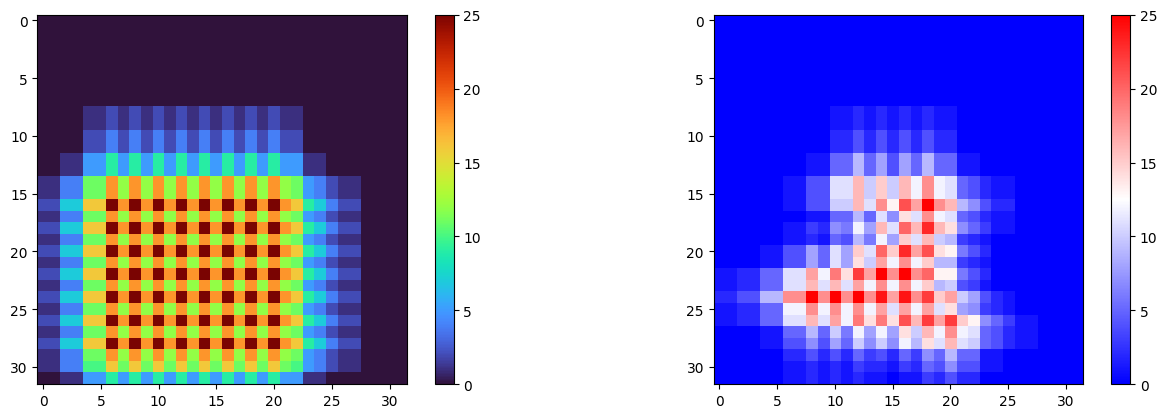

In [573]:
pc_ind = -2
pc = r.pcs[pc_ind]
cluster_ind = r.pc_ind_to_cs_cluster_inds[pc_ind]
cluster = CS_CLUSTERS[cluster_ind]
print(winner_pc_ones_counts[pc_ind])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

map1 = (CS_POINTS.T * cluster).T.sum(axis=0)
im = ax1.imshow(map1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

map2 = (CS_POINTS.T * pc).T.sum(axis=0)
im = ax2.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.show()

In [520]:
winner_pcs = []
winner_pc_ones_counts = []
winner_pc_ind_to_cs_cluster_inds = []
tp_cpavs = ob_cpavs[ob_tps]
fp_cpavs = ob_cpavs[~ob_tps]

In [523]:
print(tp_cpavs.shape[0], fp_cpavs.shape[0])

pcs_incubator = CS_CLUSTERS.copy()
assert tp_cpavs.shape[0] > 0

for cpav in tp_cpavs:
    ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
    grow = (cpav * (CS_CLUSTER_NUS * ys)[:,np.newaxis]) # how weights of each PC must grow up, matrix, ca. shape (35, 675)
    grow *= CS_CLUSTERS # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
    nomins = pcs_incubator + grow # grow weights of incubated PCs
    denoms = nomins.max(axis=1) 
    pcs_incubator = (nomins.T / denoms).T # redistribute weights

pcs = xp.where(pcs_incubator > HP_SIGNAL_PC_BINARIZE_THRES, 1.0, 0.0).astype('f')
pc_ones_counts = pcs.sum(axis=1).astype('f')
pc_ind_to_cs_cluster_inds = np.arange(pcs.shape[0])

sort_inds = xp.flip(xp.argsort(pc_ones_counts)) # sort by complexity, more complex go first
pcs = pcs[sort_inds]
pc_ones_counts = pc_ones_counts[sort_inds]
pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[sort_inds]

# Validate all observations (TP and FP) against PCs
all_cpavs = np.vstack([tp_cpavs, fp_cpavs])
ob_pcs_activation_mat = (all_cpavs @ pcs.T)
ob_pcs_activation_mat = (ob_pcs_activation_mat >= pc_ones_counts).astype('f') # row - observation, columns - binary vector of PCs activations for each ob
pc_obs_activation_mat = ob_pcs_activation_mat.T # row - pc_set, columns - binary vector of obs for which given PC is activated

# retain only accurate PCs: with TP and no FP
mask_tp = np.any(pc_obs_activation_mat[:,:tp_cpavs.shape[0]], axis=1)
mask_fp = ~np.any(pc_obs_activation_mat[:,tp_cpavs.shape[0]:], axis=1)
mask = np.argwhere(mask_tp & mask_fp).ravel()
pcs = pcs[mask]
pc_ones_counts = pc_ones_counts[mask]
pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[mask]
pc_obs_activation_mat = pc_obs_activation_mat[mask]

# get PC which reacts on majority of tp_cpavs
obs_per_pc_counts = pc_obs_activation_mat[:,:tp_cpavs.shape[0]].sum(axis=1)
winner_pc_ind = np.argmax(obs_per_pc_counts)
winner_pc_tp_cpav_mask = pc_obs_activation_mat[winner_pc_ind,:tp_cpavs.shape[0]].astype(bool)
winner_pcs.append(pcs[winner_pc_ind])
winner_pc_ones_counts.append(pc_ones_counts[winner_pc_ind])
winner_pc_ind_to_cs_cluster_inds.append(pc_ind_to_cs_cluster_inds[winner_pc_ind])

132 35


In [524]:
tp_cpavs = tp_cpavs[~winner_pc_tp_cpav_mask]
tp_cpavs.shape

(113, 675)

In [525]:
len(winner_pcs)

2

53.0


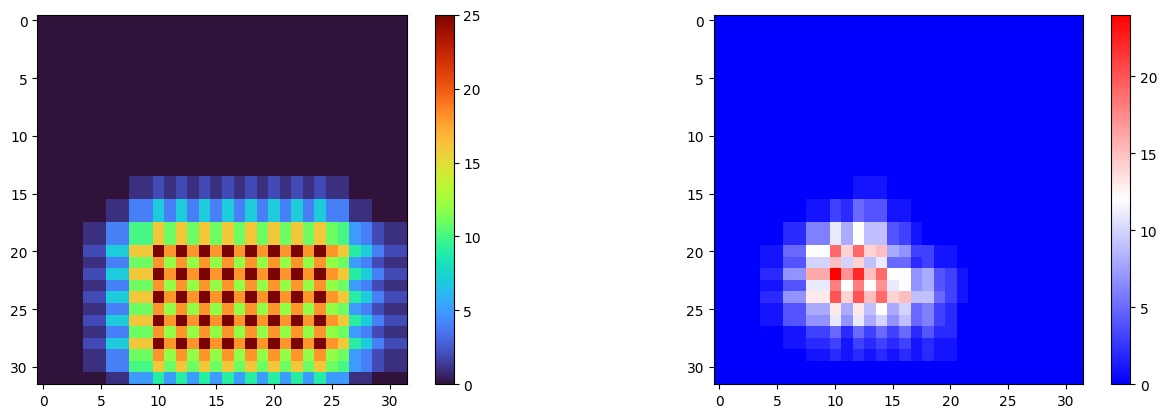

In [527]:
pc_ind = 1
pc = winner_pcs[pc_ind]
cluster_ind = winner_pc_ind_to_cs_cluster_inds[pc_ind]
cluster = CS_CLUSTERS[cluster_ind]
print(winner_pc_ones_counts[pc_ind])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

map1 = (CS_POINTS.T * cluster).T.sum(axis=0)
im = ax1.imshow(map1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

map2 = (CS_POINTS.T * pc).T.sum(axis=0)
im = ax2.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.show()

# Test

In [29]:
count = 1000
get_test_image_ids = lambda df: RNG.choice(df.index.unique(), min(count, len(df)), replace=False)
TestRunSource = namedtuple('TestRunSource', ['df_images', 'db_con', 'source_ds', 'test_image_ids'])
test_run_source = {
    'test': TestRunSource(df_test_images, test_db_con, 'test', get_test_image_ids(df_test_images)),
    'train': TestRunSource(df_train_images, train_db_con, 'train', get_test_image_ids(df_train_images)),
    'train2': TestRunSource(df_train_images, train_db_con, 'train2', train_image_ids)
}['test']

In [33]:
%%time
test_results_db_con.cursor().execute('INSERT INTO test_runs(dummy) VALUES(1)')
test_results_db_con.commit()
test_run_id = test_results_db_con.cursor().execute('SELECT MAX(test_run_id) FROM test_runs').fetchone()[0]
test_result_rows = defaultdict(list)
prod_signals_count = len(list(filter(lambda s: s.state == SignalState.PROD, SIGNALS.values())))
match_tabs = []

for image in tqdm(test_run_source.df_images.loc[test_run_source.test_image_ids].itertuples(), total=len(test_run_source.test_image_ids)):
    image_id = int(image.Index)
    image_value = image.value
    # matchee = create_matchee_cached(image)
    matchee = create_matchee(image)

    inspect_depth = 100
    cos_sim_mat = SEQ_LVS.array_active @ matchee.seq_lvs.T
    top_mat_indices = xp.argsort(cos_sim_mat, axis=None)[-inspect_depth:]
    cos_sims = xp.take(cos_sim_mat, top_mat_indices)
    top_mat_indices = xp_array_from_gpu(xp.flip(top_mat_indices))
    cos_sims = xp_array_from_gpu(xp.flip(cos_sims))

    matches = Counter()
    votes = {}
    match_tab = defaultdict(list)

    for top_mat_index, cos_sim in zip(top_mat_indices, cos_sims):
        if cos_sim < HP_SEQ_LV_COS_SIM_THRESHOLD:
            break
        
        seq_lv_ind = top_mat_index // cos_sim_mat.shape[1]
        signal = SIGNALS[seq_lv_ind]
        
        if signal.state != SignalState.PROD:
            continue
            
        matchee_seq_lv_ind = top_mat_index % cos_sim_mat.shape[1]
        matchee_seq_reading_code = matchee.seq_reading_codes[matchee_seq_lv_ind]
        matchee_seq_reading = get_sequences_reading(matchee.sequences, matchee_seq_reading_code)
        matchee_seq_xy = get_xy_sequence(get_sequence(matchee_seq_reading), matchee.si_ind_dict)
        matchee_seq_bv = calc_seq_bv(matchee_seq_xy)
        cpav = get_cs_point_activations_vec(matchee_seq_bv)
        pcs_activation_vec = (cpav @ signal.pcs.T)
        pcs_activation_vec = (pcs_activation_vec >= signal.pc_ones_counts).astype('f')
        is_match = np.any(pcs_activation_vec) # is any of PC is activated?
        is_vote = False

        if is_match and not signal.seq_lv_ind in votes:
            votes[signal.seq_lv_ind] = signal.value
            matches[signal.value] += 1
            is_vote = True
            
        #####################
        
        # matchee_seq_bvs = []
        # elozo_meshgrid = np.mgrid[-2:3, -2:3]
        
        # for elozo_dx, elozo_dy in zip(elozo_meshgrid[1].ravel(), elozo_meshgrid[0].ravel()):
        #     for deg in [-15, -10, -5, 0, 5, 10, 15]:
        #         matchee_seq_bv = calc_seq_bv2(matchee_seq_xy, signal.origin_offset, deg, np.array([elozo_dx, elozo_dy]))
        #         matchee_seq_bvs.append(matchee_seq_bv)

        # matchee_seq_bvs = xp.vstack(matchee_seq_bvs)
        # cpavs = ((matchee_seq_bvs @ CS_POINTS.T) > 0).astype('f') # how each matchee_seq_bv activated CP_POINTS, ca. shape (50, 675)
        # pcs_activation_mat = (cpavs @ signal.pcs.T)
        # pcs_activation_mat = (pcs_activation_mat >= signal.pc_ones_counts).astype('f') # row - matchee var., columns - binary vector of PCs activations
        # pcs_activation_vec = np.max(pcs_activation_mat, axis=0)
        # is_match = np.any(pcs_activation_vec) # is any of PC is activated?
        # is_vote = False

        # if is_match and not signal.seq_lv_ind in votes:
        #     votes[signal.seq_lv_ind] = signal.value
        #     matches[signal.value] += 1
        #     is_vote = True
        
        #####################

        match_tab['seq_lv_ind'].append(seq_lv_ind)
        match_tab['signal_image_id'].append(signal.image_id)
        match_tab['signal_value'].append(signal.value)
        match_tab['signal_seq_reading_code'].append(signal.seq_reading_code)
        match_tab['cos_sim'].append(cos_sim)
        match_tab['pc_activation_inds'].append(list(np.argwhere(pcs_activation_vec).ravel()))
        match_tab['is_match'].append(is_match)
        match_tab['is_vote'].append(is_vote)
        match_tab['matchee_seq_lv_ind'].append(matchee_seq_lv_ind)
        match_tab['matchee_seq_reading_code'].append(matchee_seq_reading_code)

    if matches:
        infer_value = matches.most_common(1)[0][0]
    else:
        # infer_value = ''
        
        if len(match_tab) > 0:
            # Dirty hack to fix low infers
            infer_value = match_tab['signal_value'][0]
        else:
            infer_value = ''
    
    df_match_tab = pd.DataFrame(match_tab)
    df_match_tab['test_image_id'] = image_id
    df_match_tab['true_value'] = image_value
    match_tabs.append(df_match_tab)
    
    test_result_rows['test_run_id'].append(test_run_id)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['notebook_fname'].append(notebook_fname)
    test_result_rows['cortical_columns'].append(f'[{','.join([])}]')
    test_result_rows['train_images_count'].append(len(TRAIN_UNIQUE_IMAGE_IDS))
    test_result_rows['train_runs_count'].append(TRAIN_RUNS_COUNT)
    test_result_rows['source_ds'].append(test_run_source.source_ds)
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    test_result_rows['matches'].append(str(matches))
    test_result_rows['prod_signals_count'].append(prod_signals_count)

df_test_results_for_run = pd.DataFrame(test_result_rows)
df_test_results_for_run['timestamp'] = datetime.datetime.now()

if DBUtils.is_table_exists(test_results_db_con, 'test_results'):
    DBUtils.ensure_table_columns(test_results_db_con, 'test_results', list(df_test_results_for_run.columns))
    
df_test_results_for_run.to_sql(name='test_results', con=test_results_db_con, if_exists='append')
pd.DataFrame({'test_run_id': [test_run_id], 'match_tabs': [pickle.dumps(match_tabs)]}).to_sql(name='test_run_artifacts', con=test_results_db_con, if_exists='append');

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 6min 37s, sys: 2.37 s, total: 6min 39s
Wall time: 1min 3s


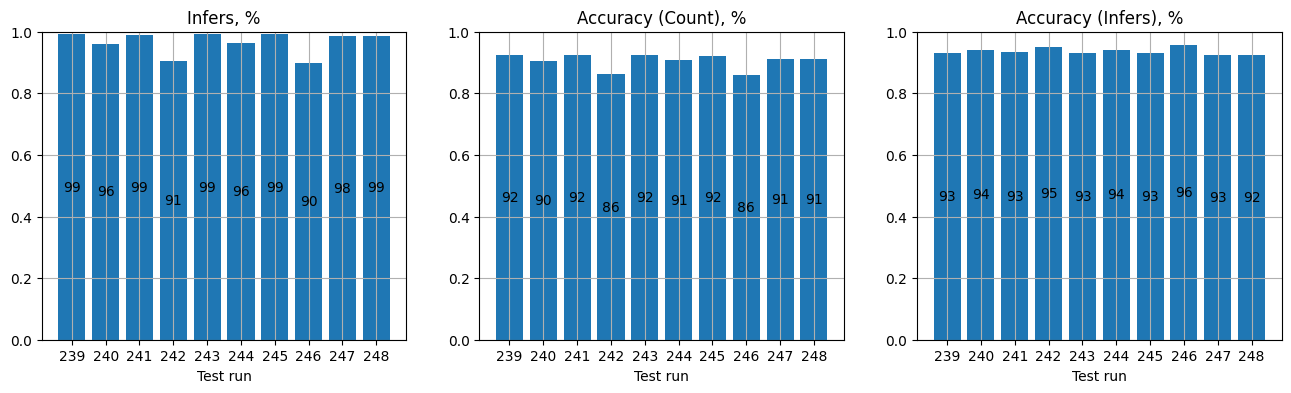

,timestamp,notebook_fname,source_ds,train_images_count,prod_signals_count,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
239,2025-06-05 15:32:29.665913,mnist_recognition58.ipynb,test,6580,1274,1000,991,924,0.991,0.924,0.932392
240,2025-06-05 15:38:58.079107,mnist_recognition58.ipynb,test,6580,1274,1000,961,905,0.961,0.905,0.941727
241,2025-06-05 15:47:01.160461,mnist_recognition58.ipynb,test,6580,1274,1000,990,924,0.990,0.924,0.933333
242,2025-06-06 09:36:52.000305,mnist_recognition58.ipynb,test,6580,1274,1000,906,862,0.906,0.862,0.951435
243,2025-06-06 09:39:56.364451,mnist_recognition58.ipynb,test,6580,1274,1000,991,924,0.991,0.924,0.932392
244,2025-06-06 09:48:52.938619,mnist_recognition58.ipynb,test,6580,1274,1000,963,907,0.963,0.907,0.941848
245,2025-06-06 09:55:17.034534,mnist_recognition58.ipynb,test,6580,1274,1000,991,922,0.991,0.922,0.930373
246,2025-06-09 11:44:31.469352,mnist_recognition59.ipynb,test,6563,1347,1000,900,860,0.900,0.860,0.955556
247,2025-06-09 11:46:05.519317,mnist_recognition59.ipynb,test,6563,1347,1000,985,912,0.985,0.912,0.925888


In [34]:
df_test_results2 = pd.read_sql_query('''
SELECT * FROM test_results 
WHERE test_run_id IN (SELECT test_run_id FROM test_runs ORDER BY test_run_id DESC LIMIT 10) 
ORDER BY test_run_id ASC
''', con=test_results_db_con)
df_test_results2['test_run_id'] = df_test_results2['test_run_id'].astype(int)
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'timestamp': 'first',
                                                                     'config_variant': 'first', 
                                                                     'notebook_fname': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'prod_signals_count': 'first',
                                                                     'train_runs_count': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.sort_values(by=['test_run_id'], inplace=True)
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2[['timestamp', 'notebook_fname', 'source_ds', 'train_images_count', 'prod_signals_count', 'count', 'infers', 'correct_infers', 'infer_ratio', 'accuracy_count', 'accuracy_infers']]

## analyze

In [35]:
df_incorrect = df_test_results_for_run.loc[df_test_results_for_run.true_value != df_test_results_for_run.infer_value]
df_incorrect = df_incorrect[['test_image_id', 'true_value', 'infer_value', 'match_tab_index']]
df_incorrect.head(20)

,test_image_id,true_value,infer_value,match_tab_index
8,100007249,2,,8
16,100007676,5,6,16
17,100001494,7,0,17
19,100007386,2,8,19
76,100001694,8,0,76
87,100009183,4,3,87
89,100005736,6,3,89
90,100007013,2,4,90
127,100009045,7,2,127
140,100002386,4,7,140


In [74]:
match_tab_index = 140
match_tab = match_tabs[match_tab_index]
# column_names = ['test_image_id', 'true_value', 'signal_value', 'is_match', 'is_vote', 
#                 'seq_lv_ind', 'signal_image_id']
# match_tab.head(10)[column_names]
match_tab.head(20)

,seq_lv_ind,signal_image_id,signal_value,signal_seq_reading_code,cos_sim,pc_activation_inds,is_match,is_vote,matchee_seq_lv_ind,matchee_seq_reading_code,test_image_id,true_value
0,974,36664,4,"((0, 0), (1, 0))",0.795009,[],False,False,1,"((0, 0), (1, 0), (2, 1))",100002386,4
1,974,36664,4,"((0, 0), (1, 0))",0.777736,[],False,False,0,"((0, 0), (1, 0), (2, 0))",100002386,4
2,1147,58677,1,"((0, 0), (1, 0), (2, 0))",0.744069,[],False,False,16,"((1, 0), (0, 0), (2, 0))",100002386,4
3,1208,1008,4,"((0, 0), (1, 0))",0.741736,[],False,False,1,"((0, 0), (1, 0), (2, 1))",100002386,4
4,154,54109,4,"((0, 0), (1, 0), (2, 0))",0.734780,[],False,False,1,"((0, 0), (1, 0), (2, 1))",100002386,4
5,1208,1008,4,"((0, 0), (1, 0))",0.725621,[],False,False,0,"((0, 0), (1, 0), (2, 0))",100002386,4
6,1280,40308,7,"((0, 0), (1, 0))",0.717359,[1],True,True,1,"((0, 0), (1, 0), (2, 1))",100002386,4
7,61,1172,4,"((0, 0), (1, 0), (2, 0), (3, 0))",0.713210,[],False,False,3,"((0, 0), (1, 1), (2, 1))",100002386,4
8,1052,47709,1,"((0, 0), (1, 0))",0.712168,[],False,False,21,"((1, 1), (0, 0), (2, 1))",100002386,4
9,140,14703,4,"((0, 0), (1, 0))",0.709062,[],False,False,3,"((0, 0), (1, 1), (2, 1))",100002386,4


In [79]:
df_match_tab_row = match_tab.iloc[10]
test_image_id = df_match_tab_row['test_image_id']

if test_image_id >= 100_000_000:
    df_test_image = next(df_test_images.loc[[test_image_id]].itertuples())
else:
    df_test_image = next(df_train_images.loc[[test_image_id]].itertuples())

matchee = create_matchee(df_test_image, df_match_tab_row['matchee_seq_reading_code'])
matchee_seq_reading = get_sequences_reading(matchee.sequences, df_match_tab_row['matchee_seq_reading_code'])
# matchee = create_matchee(df_test_image)
signal = SIGNALS[df_match_tab_row['seq_lv_ind']]
len(signal.observations.values()), len(signal.pcs)

(62, 7)


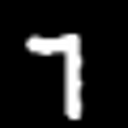
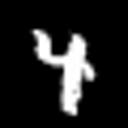

In [80]:
images = [get_raw_image(signal.image_id), get_raw_image(test_image_id)]
captions = [f'signal, {signal.image_id}, obs={len(signal.observations.values())}, PCs={len(signal.pcs)}', f'matchee, {matchee.image_id}']
display_images(images, captions=captions)

NameError: name 'matchee_seq_bv2' is not defined

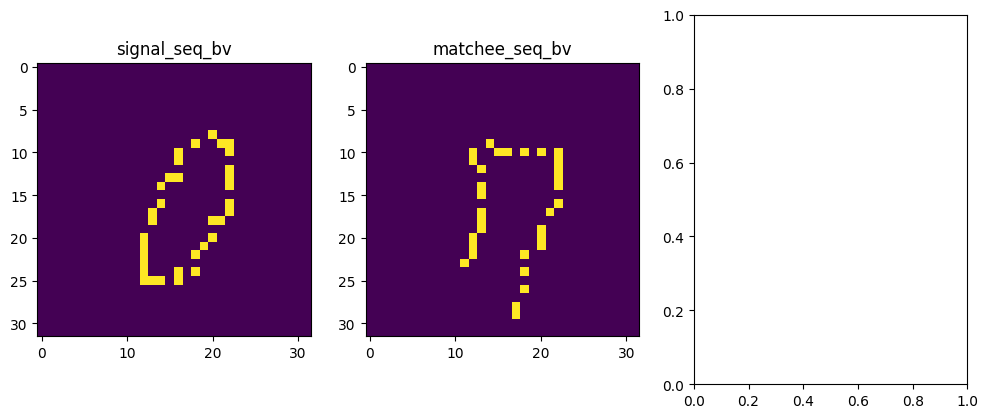

In [45]:
signal_seq_xy = get_xy_sequence(get_sequence(signal.seq_reading), signal.si_ind_dict)
signal_seq_bv = calc_seq_bv(signal_seq_xy)
matchee_seq_xy = get_xy_sequence(get_sequence(matchee_seq_reading), matchee.si_ind_dict)
matchee_seq_bv = calc_seq_bv(matchee_seq_xy)
# matchee_seq_bv2 = calc_seq_bv2(matchee_seq_xy, signal.origin_offset, 15, np.array([0, 0]))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(12)
ax1.imshow(signal_seq_bv.reshape(HP_COMBI_SPACE_SIZE, -1))
ax1.set_title('signal_seq_bv')
ax2.imshow(matchee_seq_bv.reshape(HP_COMBI_SPACE_SIZE, -1))
ax2.set_title('matchee_seq_bv')
ax3.imshow(matchee_seq_bv2.reshape(HP_COMBI_SPACE_SIZE, -1))
ax3.set_title('matchee_seq_bv2')
plt.show()

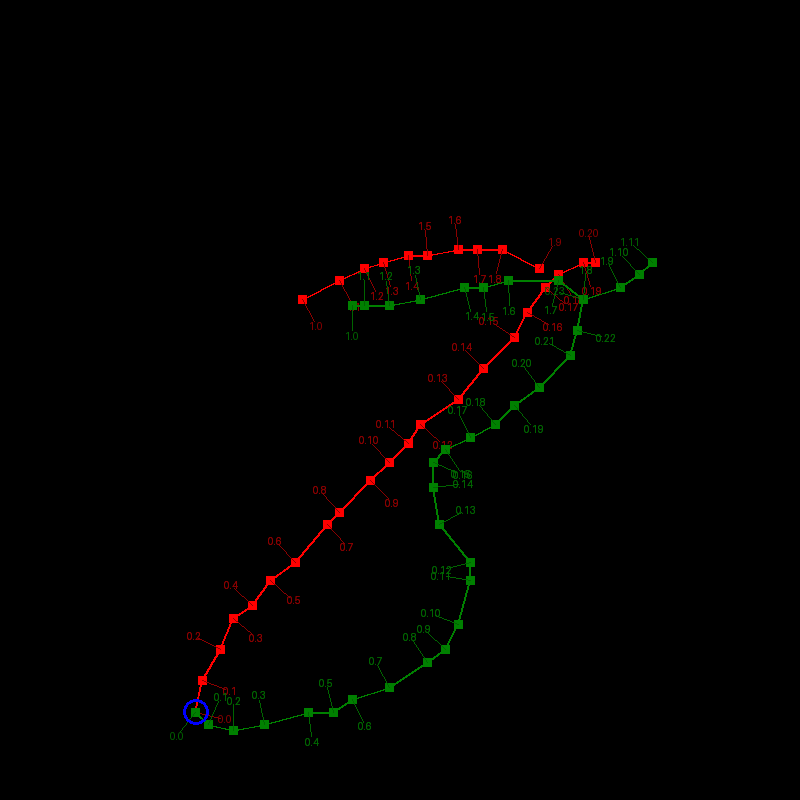

In [684]:
canvas = render_seq_reading(signal.seq_reading, signal.si_ind_dict, origin_offset=signal.origin_offset)
render_seq_reading(matchee_seq_reading, matchee.si_ind_dict, origin_offset=signal.origin_offset, canvas=canvas, palette={'all': 'green', 'normal': 'darkgreen', 'start': 'blue'})

cs_cluster_ind=20, pc_ones_count=38, obs=Counter({False: 89, True: 33})


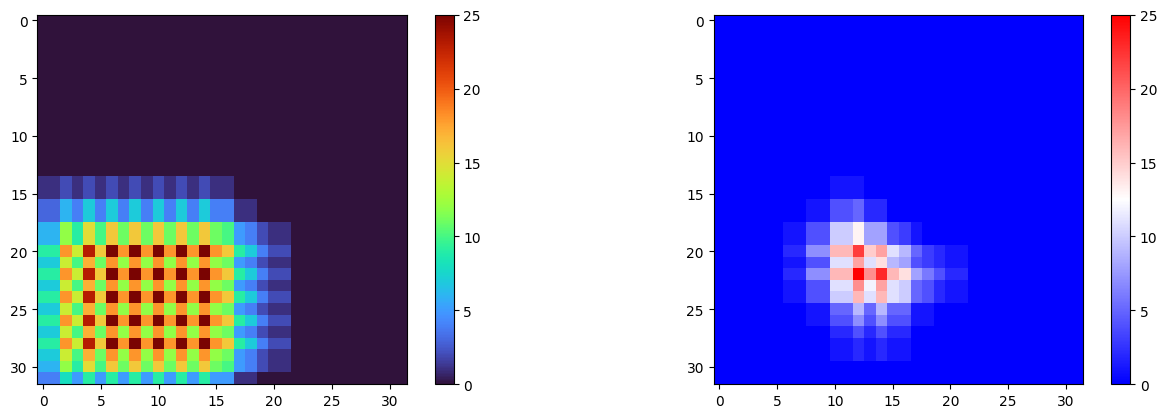

In [47]:
pc_ind = 1
cs_cluster_ind = signal.pc_ind_to_cs_cluster_inds[pc_ind]
obs_counter = Counter(map(lambda ob: ob.is_correct_match, signal.observations.values()))
print(f'cs_cluster_ind={cs_cluster_ind}, pc_ones_count={signal.pc_ones_counts[pc_ind]:.0f}, obs={obs_counter}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

map1 = (CS_POINTS.T * CS_CLUSTERS[cs_cluster_ind]).T.sum(axis=0)
im = ax1.imshow(map1.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo') 
ax1.figure.colorbar(im, ax=ax1)

map2 = (CS_POINTS.T * signal.pcs[pc_ind]).T.sum(axis=0)
im = ax2.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='bwr')
ax2.figure.colorbar(im, ax=ax2)

plt.show()


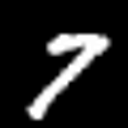
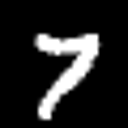
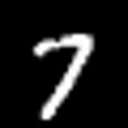
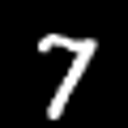
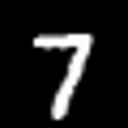
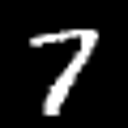
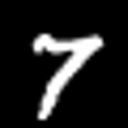
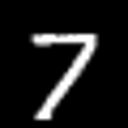
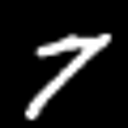
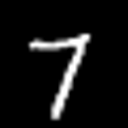
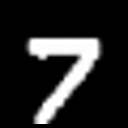
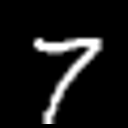
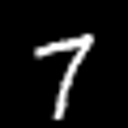
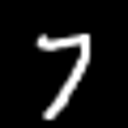
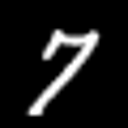
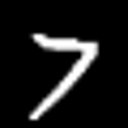
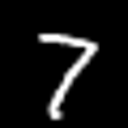
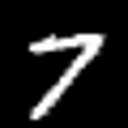
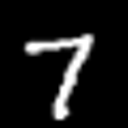
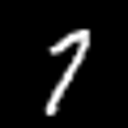
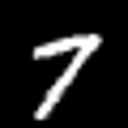
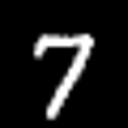
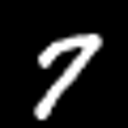
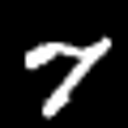
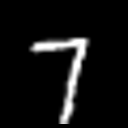
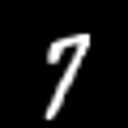
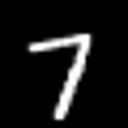
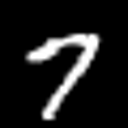
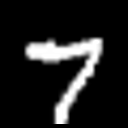
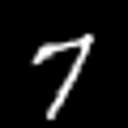
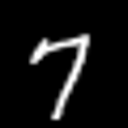
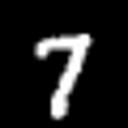
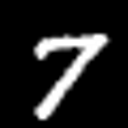
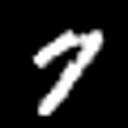
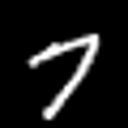
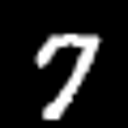
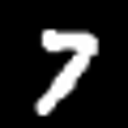
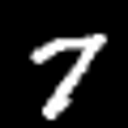
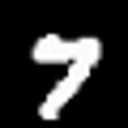
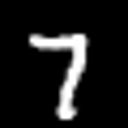
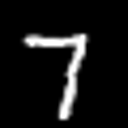
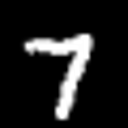
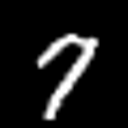
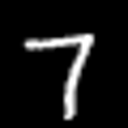
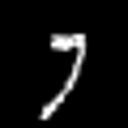
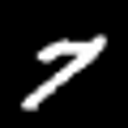
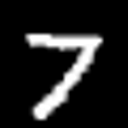
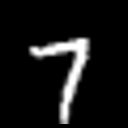
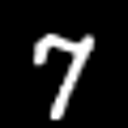
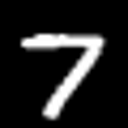
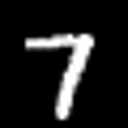
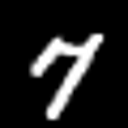
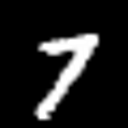
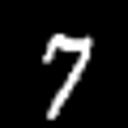
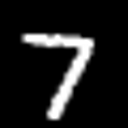
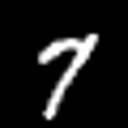
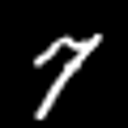
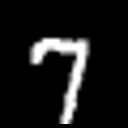
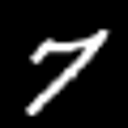
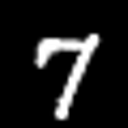
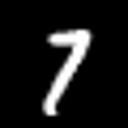
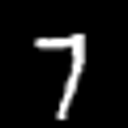
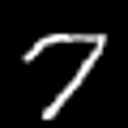
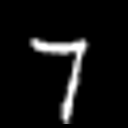
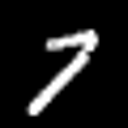
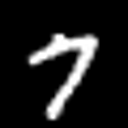
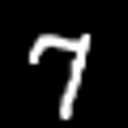
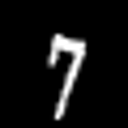
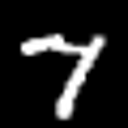
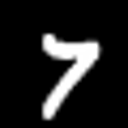
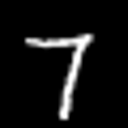
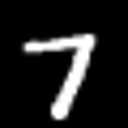
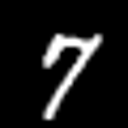
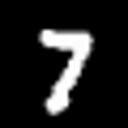
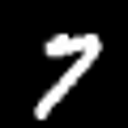
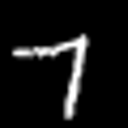
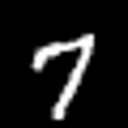
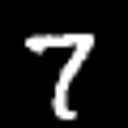
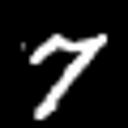
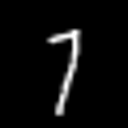
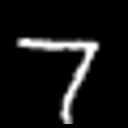
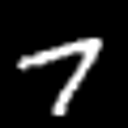
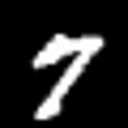
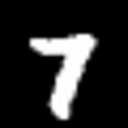
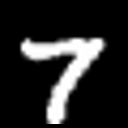
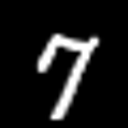
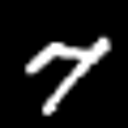
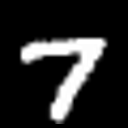
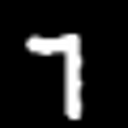
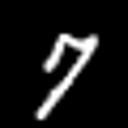
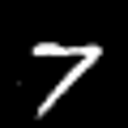
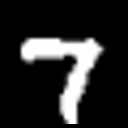
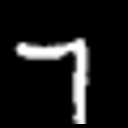
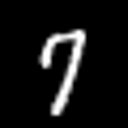
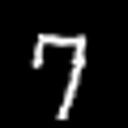
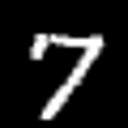
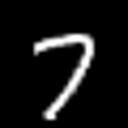
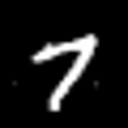
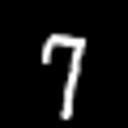
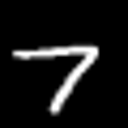
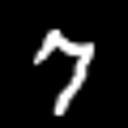
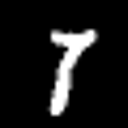
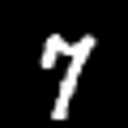
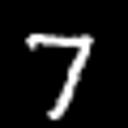
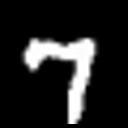
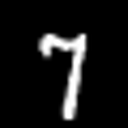
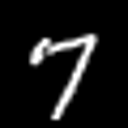
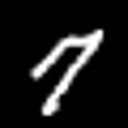
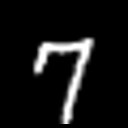
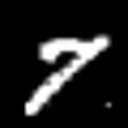
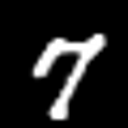
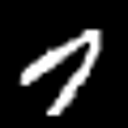

In [695]:
tp_obs = list(filter(lambda ob: ob.is_correct_match, signal.observations.values()))
tp_obs.sort(key=lambda ob: -ob.cos_sim)
fp_obs = list(filter(lambda ob: not ob.is_correct_match, signal.observations.values()))

captions = list(map(lambda ob: f'{ob.cos_sim:.2f}, {ob.image_id}', tp_obs))
display_images_grid(list(map(lambda ob: get_raw_image(ob.image_id), tp_obs)), captions=captions, col_count=10)


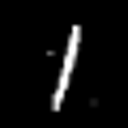
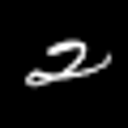
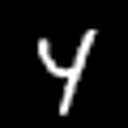
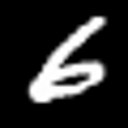
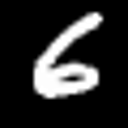
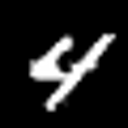
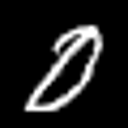
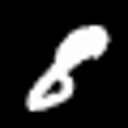
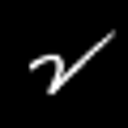
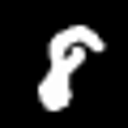
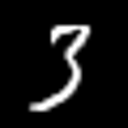
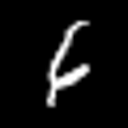
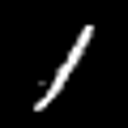
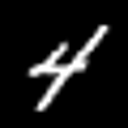
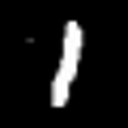
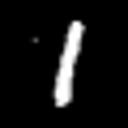
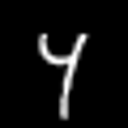

In [730]:
display_images_grid(list(map(lambda ob: get_raw_image(ob.image_id), fp_obs)), col_count=10)

## xxx

In [825]:
LearnSignalPcsCycleResult2 = namedtuple('LearnSignalPcsCycleResult2', ['pc', 'pc_ones_count', 'cs_cluster_ind', 'tp_cpav_mask', 'thres', 'pcs_incubator', 'pc_obs_activation_mat'])

def learn_signal_pcs_cycle2(tp_cpavs, fp_cpavs, thres_direction, clusters, cluster_nus):
    assert tp_cpavs.shape[0] > 0
    pcs_incubator = clusters.copy()
    
    for cpav in tp_cpavs:
        ys = cpav @ pcs_incubator.T # how each PC in incubator reacted on cpav, ca. shape (35,)
        grow = (cpav * (cluster_nus * ys)[:,np.newaxis]) # how weights of each PC must grow up in response co cpav, matrix, ca. shape (35, 675)
        grow *= clusters # masking, only allow weights which belong to clusters to grow up, matrix, ca. shape (35, 675)
        nomins = pcs_incubator + grow # grow weights of incubated PCs
        denoms = nomins.max(axis=1) 
        pcs_incubator = (nomins.T / denoms).T # redistribute weights

    if thres_direction == 'UP':
        thres_list = np.linspace(0.75, 0.99, 20)
    else:
        assert thres_direction == 'DOWN', thres_direction
        thres_list = np.linspace(0.99, 0.75, 20)

    # the higher thres the more coverage is (with thres close to 1 we are left with couple of CS_POINTS only)
    for thres in thres_list:
        pcs = xp.where(pcs_incubator > thres, 1.0, 0.0).astype('f')
        pc_ones_counts = pcs.sum(axis=1).astype('f')
        # print(f'thres={thres}, pc_ones_counts={pc_ones_counts}')
        pc_ind_to_cs_cluster_inds = np.arange(pcs.shape[0])
        
        sort_inds = xp.flip(xp.argsort(pc_ones_counts)) # sort by complexity, more complex go first
        pcs = pcs[sort_inds]
        pc_ones_counts = pc_ones_counts[sort_inds]
        pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[sort_inds]
        
        # Validate all observations (TP and FP) against PCs
        all_cpavs = xp.vstack([tp_cpavs, fp_cpavs])
        ob_pcs_activation_mat = (all_cpavs @ pcs.T)
        ob_pcs_activation_mat = (ob_pcs_activation_mat >= pc_ones_counts).astype('f') # row - observation, columns - binary vector of PCs activations for each ob
        pc_obs_activation_mat = ob_pcs_activation_mat.T # row - pc, columns - binary vector of obs for which given PC is activated
        
        # retain only accurate PCs: with TP and no FP
        mask_tp = xp.any(pc_obs_activation_mat[:,:tp_cpavs.shape[0]], axis=1)
        mask_fp = ~xp.any(pc_obs_activation_mat[:,tp_cpavs.shape[0]:], axis=1)
        mask = xp.argwhere(mask_tp & mask_fp).ravel()

        # print(f'thres={thres:.3f}, tps={np.argwhere(pc_obs_activation_mat[0,:tp_cpavs.shape[0]]).ravel()}, fps={np.argwhere(pc_obs_activation_mat[0,tp_cpavs.shape[0]:]).ravel()}, mask.shape[0]={mask.shape[0]}')
        if mask.shape[0] > 0:
            pcs = pcs[mask]
            pc_ones_counts = pc_ones_counts[mask]
            pc_ind_to_cs_cluster_inds = pc_ind_to_cs_cluster_inds[mask]
            pc_obs_activation_mat = pc_obs_activation_mat[mask]
            
            # get PC which reacted on majority of tp_cpavs
            obs_per_pc_counts = pc_obs_activation_mat[:,:tp_cpavs.shape[0]].sum(axis=1)
            winner_pc_ind = np.argmax(obs_per_pc_counts)
            return LearnSignalPcsCycleResult2(pc=pcs[winner_pc_ind], 
                                               pc_ones_count=pc_ones_counts[winner_pc_ind],
                                               cs_cluster_ind=pc_ind_to_cs_cluster_inds[winner_pc_ind],
                                               tp_cpav_mask=pc_obs_activation_mat[winner_pc_ind,:tp_cpavs.shape[0]].astype(bool),
                                              thres=thres,
                                               pcs_incubator=pcs_incubator, pc_obs_activation_mat=pc_obs_activation_mat)
        
    # Failed to separate TP and FP =(
    return LearnSignalPcsCycleResult2(pc=None, pc_ones_count=None, cs_cluster_ind=-1, tp_cpav_mask=None, thres=-1, pcs_incubator=pcs_incubator, pc_obs_activation_mat=pc_obs_activation_mat)

In [834]:
seq_xy = get_xy_sequence(get_sequence(signal.seq_reading), signal.si_ind_dict)
center_xy = np.mean((seq_xy - seq_xy[0]), axis=0)
origin_offset = -center_xy + np.full(2, config.sample_size / 2) # offset to move figure's center to center of future bitmap

ob_tps = np.array(list(map(lambda ob: ob.is_correct_match, signal.observations.values()))) # true positives
ob_seq_xys = map(lambda ob: get_xy_sequence(get_sequence(ob.seq_reading), ob.si_ind_dict), signal.observations.values())
ob_seq_bvs = map(lambda ob_seq_xy: calc_seq_bv(ob_seq_xy, origin_offset), ob_seq_xys)
ob_seq_bvs = xp.vstack(list(ob_seq_bvs))
ob_cpavs = ((ob_seq_bvs @ CS_POINTS.T) > 0).astype('f') # how each seq_bv activated CP_POINTS, ca. shape (50, 675)

ob_tp_cpavs = ob_cpavs[ob_tps]
ob_fp_cpavs = ob_cpavs[~ob_tps]

pcs, pc_ones_counts, pc_ind_to_cs_cluster_inds = [], [], []

xxx_clusters = np.ones((1, CS_CLUSTERS.shape[1]))
xxx_cluster_ones_counts = xxx_clusters.sum(axis=1)
xxx_cluster_nus = 1 / xxx_cluster_ones_counts

while ob_tp_cpavs.shape[0] > 0:
    print(f'DOWN: TP={ob_tp_cpavs.shape[0]}, FP={ob_fp_cpavs.shape[0]}')
    cycle_result1 = learn_signal_pcs_cycle2(ob_tp_cpavs, ob_fp_cpavs, 'DOWN', xxx_clusters, xxx_cluster_nus)

    if cycle_result1.pc is None:
        print('DOWN failed')
        break

    print(f'DOWN: covered={cycle_result1.tp_cpav_mask.sum()}, thres={cycle_result1.thres}')
    ob_tp_cpavs2 = ob_tp_cpavs[~cycle_result1.tp_cpav_mask]
    ob_tp_cpavs = ob_tp_cpavs[~cycle_result1.tp_cpav_mask] # exclude from ob_tp_cpavs samples which are governed by returned PC

    print(f'UP: TP={ob_tp_cpavs2.shape[0]}, FP={ob_fp_cpavs.shape[0]}')
    # cycle_result2 = learn_signal_pcs_cycle2(ob_tp_cpavs2, ob_fp_cpavs, 'UP', xxx_clusters, xxx_cluster_nus)
    cycle_result2 = learn_signal_pcs_cycle2(ob_tp_cpavs2, ob_fp_cpavs, 'UP', cycle_result1.pc[np.newaxis,:], 1 / cycle_result1.pc[np.newaxis,:].sum(axis=1))

    if cycle_result2.pc is None:
        print('UP failed')
        break

    print(f'UP: covered={cycle_result2.tp_cpav_mask.sum()}, thres={cycle_result2.thres}')
        
    pcs.append(cycle_result2.pc)
    pc_ones_counts.append(cycle_result2.pc_ones_count)
    pc_ind_to_cs_cluster_inds.append(cycle_result2.cs_cluster_ind)

if pcs:
    pcs = xp.vstack(pcs)
    pc_ones_counts = xp.hstack(pc_ones_counts)
else:
    pcs = xp.array([])
    pc_ones_counts = xp.array([])
    
# return signal._replace(origin_offset=origin_offset, pcs=pcs, pc_ones_counts=pc_ones_counts, pc_ind_to_cs_cluster_inds=pc_ind_to_cs_cluster_inds)

DOWN: TP=112, FP=17
DOWN: covered=59, thres=0.9521052631578948
UP: TP=53, FP=17
UP failed


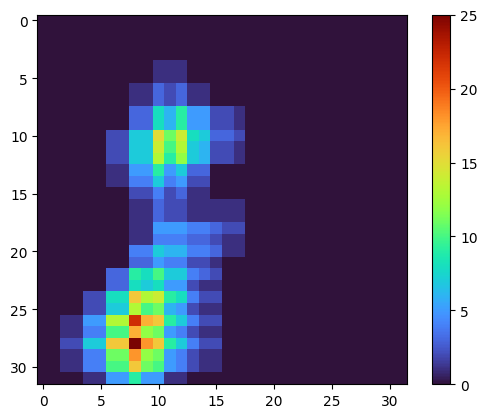

In [836]:
map2 = (CS_POINTS.T * cycle_result1.pc).T.sum(axis=0)
plt.imshow(map2.reshape(HP_COMBI_SPACE_SIZE, -1), cmap='turbo')
plt.colorbar()
plt.show()

In [838]:
def decompose_matrix(M):
  '''Decomposes the matrix M using Singular Value Decomposition (SVD).'''
  U, S, V = np.linalg.svd(M)  # Perform SVD 
  print('U shape:', U.shape) 
  print('S shape:', S.shape)
  print('V shape:', V.shape)

  # Adjust matrix shapes to ensure U (m x n), S (n x n), V (n x n):
  U = U[:, :S.shape[0]]  # Limit U to the number of singular values 
  S = np.diag(S)  # Convert S (a vector) into a diagonal matrix
  print('Adjusted U shape:', U.shape)
  print('Adjusted S shape:', S.shape)
  print('Adjusted V shape:', V.shape)

  return U, S, V

# def reconstruct_matrix(U, S, V, r):
#   '''Reconstructs the matrix using the SVD components with rank r.''' 
#   # print('\nReconstructing matrix with rank=', r)
#   R = U[:, :r] @ S[:r, :r] @ V[:r, :]  # Use rank-reduced components for approximation 
#   # print(R)
#   # print('R shape:', R.shape)  # Output shape of the approximated matrix
#   return R

def reconstruct_matrix(U, S, V, ranks):
    return U[:, ranks] @ np.take(np.take(S, ranks, axis=0), ranks, axis=1) @ V[ranks, :]

def compare_matrices(M, R):
  '''Calculates the difference and relative difference between the original and 
      reconstructed matrix.'''
  D = M - R  # Element-wise difference
  M_norm = np.linalg.norm(M, 'fro')  # Frobenius norm of original matrix
  D_norm = np.linalg.norm(D, 'fro')  # Frobenius norm of difference matrix
  print('Diff:\n', np.array_str(D, precision=2, suppress_small=True))  # Print differences
  return D_norm / M_norm  # Calculate the relative difference ratio

In [840]:
U, S, V = decompose_matrix(signal_seq_bv.reshape(32, -1))

U shape: (32, 32)
S shape: (32,)
V shape: (32, 32)
Adjusted U shape: (32, 32)
Adjusted S shape: (32, 32)
Adjusted V shape: (32, 32)


In [841]:
-np.sort(-np.unique(S)), -np.round(np.sort(-np.unique(S ** 2)), decimals=0), -np.round(np.sort(-(np.unique(S ** 2) / np.sum((S ** 2).ravel()))), decimals=2) 

(array([2.9769928e+00, 1.8705206e+00, 1.7320508e+00, 1.4142135e+00,
        1.0000000e+00, 6.2579817e-01, 4.9703395e-01, 2.3255131e-16,
        8.5801440e-17, 1.2726092e-17, 0.0000000e+00], dtype=float32),
 array([9., 3., 3., 2., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.32, 0.12, 0.11, 0.07, 0.04, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ],
       dtype=float32))

In [859]:
32 * 15 * 2

960

U shape: (32, 32)
S shape: (32,)
V shape: (32, 32)
Adjusted U shape: (32, 32)
Adjusted S shape: (32, 32)
Adjusted V shape: (32, 32)
U shape: (32, 32)
S shape: (32,)
V shape: (32, 32)
Adjusted U shape: (32, 32)
Adjusted S shape: (32, 32)
Adjusted V shape: (32, 32)


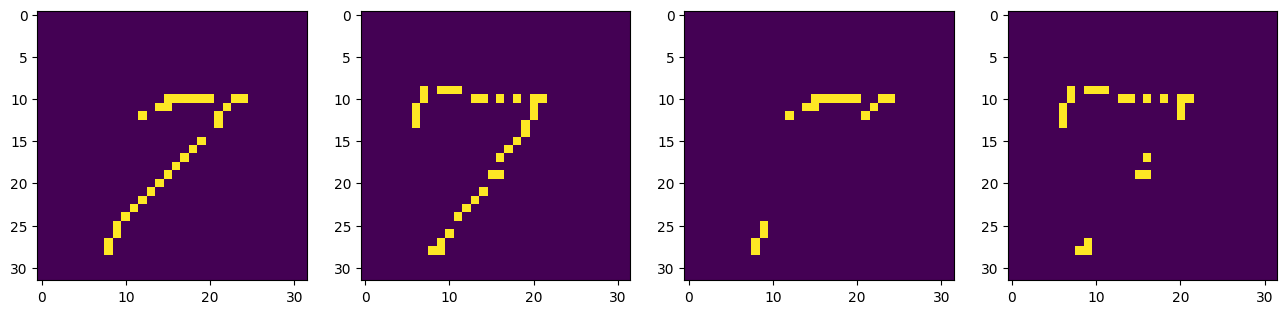

In [887]:
U0, S0, V0 = decompose_matrix(signal_seq_bv.reshape(32, -1))
U_, S_, V_ = decompose_matrix(ob_seq_bvs[5].reshape(32, -1))
ranks = [0, 1, 2, 3, 4]
signal_seq_bv_r = np.where(reconstruct_matrix(U0, S0, V0, ranks) > 0.5, 1, 0)
ob_seq_bvs_ = np.where(reconstruct_matrix(U_, S_, V_, ranks) > 0.5, 1, 0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_figwidth(16)
ax1.imshow(signal_seq_bv.reshape(32, -1))
ax2.imshow(ob_seq_bvs[5].reshape(32, -1))
ax3.imshow(signal_seq_bv_r)
ax4.imshow(ob_seq_bvs_)
plt.show()

In [938]:
from scipy.fftpack import dct, idct
dct_coeffs0 = dct(signal_seq_bv, norm='ortho')
dct_coeffs_ = dct(ob_seq_bvs[5], norm='ortho')

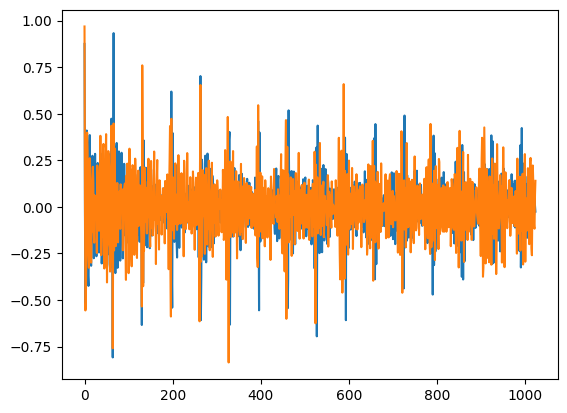

In [964]:
plt.plot(np.arange(1024), dct_coeffs0)
plt.plot(np.arange(1024), dct_coeffs_)
plt.show()

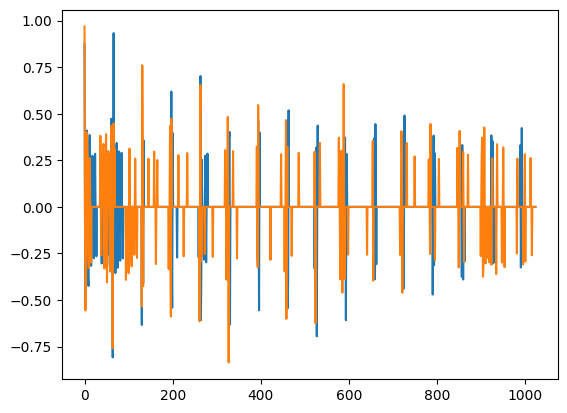

np.float32(0.30676335)

In [983]:
c1 = np.where(np.abs(dct_coeffs0) < 0.25, 0, dct_coeffs0)
c2 = np.where(np.abs(dct_coeffs_) < 0.25, 0, dct_coeffs_)

plt.plot(np.arange(1024), c1)
plt.plot(np.arange(1024), c2)
plt.show()
(c1 @ c2) / (np.linalg.norm(c1) * np.linalg.norm(c2))

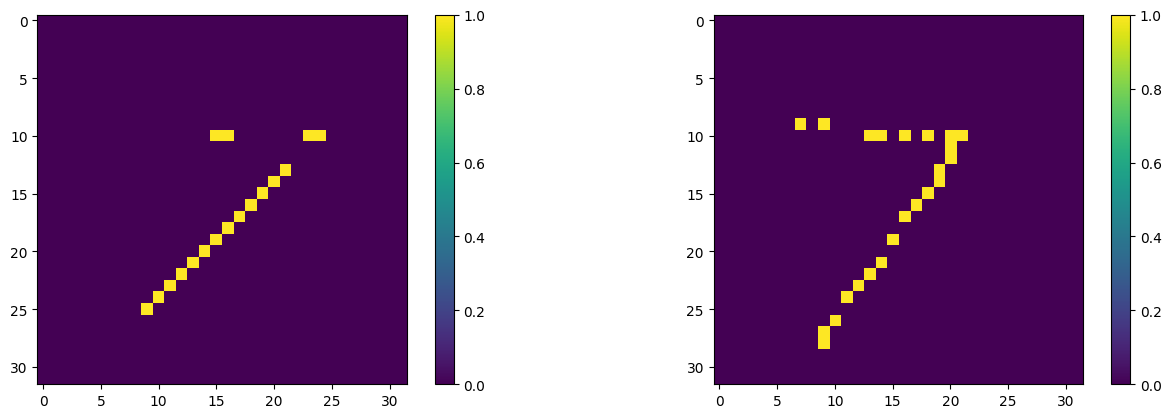

In [979]:
# cn = 600
# dct_coeffs0_trunc = dct_coeffs0.copy()
# dct_coeffs0_trunc[cn:] = 0
# dct_coeffs_trunk = dct_coeffs_.copy()
# dct_coeffs_trunk[cn:] = 0
dct_coeffs0_trunc = np.where(np.abs(dct_coeffs0) < 0.25, 0, dct_coeffs0)
dct_coeffs_trunk = np.where(np.abs(dct_coeffs_) < 0.25, 0, dct_coeffs_)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

z0 = idct(dct_coeffs0_trunc, norm='ortho')
im = ax1.imshow(np.where(z0.reshape(32, -1) > 0.5, 1, 0))
# im = ax1.imshow(z0.reshape(32, -1))
ax1.figure.colorbar(im, ax=ax1)

z_ = idct(dct_coeffs_trunk, norm='ortho')
im = ax2.imshow(np.where(z_.reshape(32, -1) > 0.5, 1, 0))
# im = ax2.imshow(z_.reshape(32, -1))
ax2.figure.colorbar(im, ax=ax2)

plt.show()

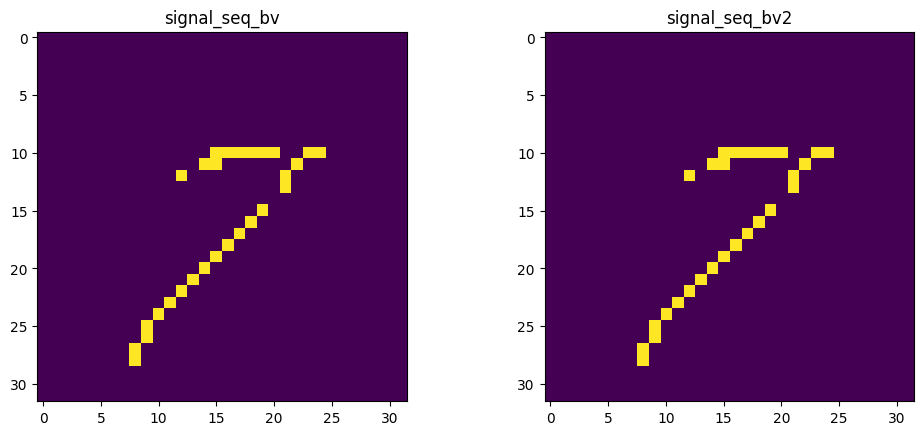

In [1047]:
signal_seq_bv = calc_seq_bv(signal_seq_xy, signal.origin_offset)
signal_seq_bv2 = calc_seq_bv2(signal_seq_xy, signal.origin_offset, 0, np.array([0, 0]))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.imshow(signal_seq_bv.reshape(HP_COMBI_SPACE_SIZE, -1))
ax1.set_title('signal_seq_bv')
ax2.imshow(signal_seq_bv2.reshape(HP_COMBI_SPACE_SIZE, -1))
ax2.set_title('signal_seq_bv2')
plt.show()

In [1048]:
dc0 = dct(signal_seq_bv, norm='ortho')
dc2 = dct(signal_seq_bv2, norm='ortho')

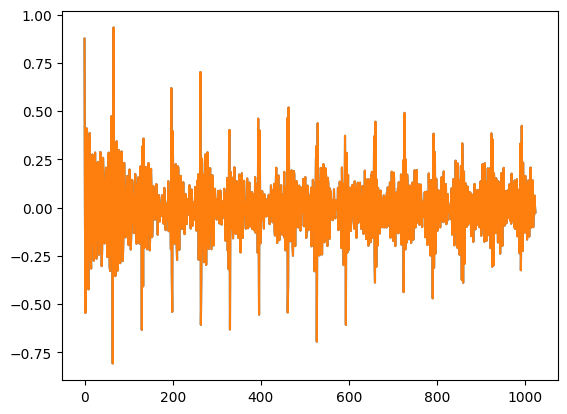

np.float32(0.99999994)

In [1049]:
# c1 = np.where(np.abs(dc0) < 0.25, 0, dc0)
# c2 = np.where(np.abs(dc2) < 0.25, 0, dc2)

c1 = np.where(np.abs(dc0) < 0.0, 0, dc0)
c2 = np.where(np.abs(dc2) < 0.0, 0, dc2)

plt.plot(np.arange(1024), c1)
plt.plot(np.arange(1024), c2)
plt.show()
(c1 @ c2) / (np.linalg.norm(c1) * np.linalg.norm(c2))

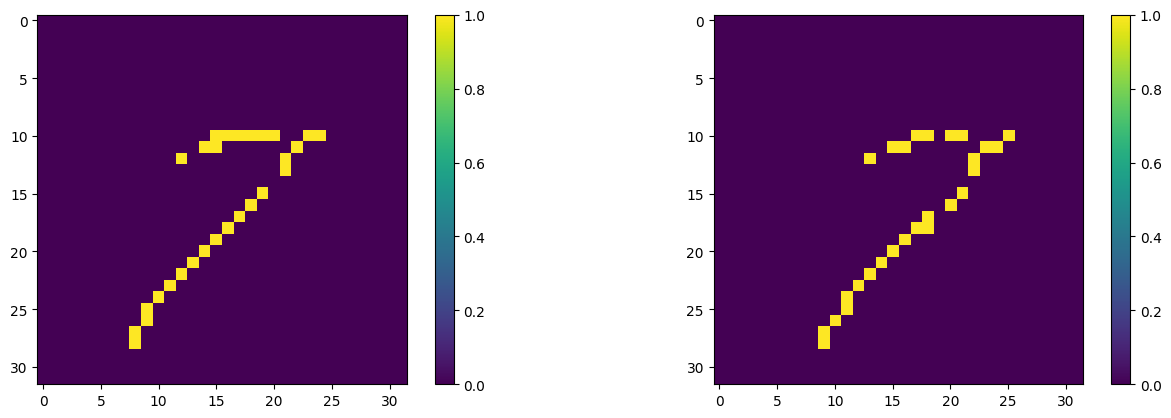

In [1043]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

z0 = idct(c1, norm='ortho')
# im = ax1.imshow(np.where(z0.reshape(32, -1) > 0.5, 1, 0))
im = ax1.imshow(z0.reshape(32, -1))
ax1.figure.colorbar(im, ax=ax1)

z2 = idct(c2, norm='ortho')
# im = ax2.imshow(np.where(z2.reshape(32, -1) > 0.5, 1, 0))
im = ax2.imshow(z2.reshape(32, -1))
ax2.figure.colorbar(im, ax=ax2)

plt.show()

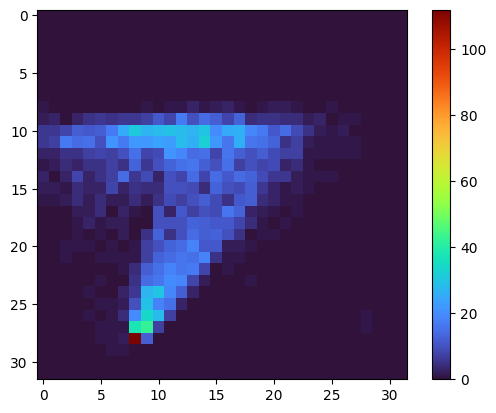

In [1065]:
combo_bv = ob_seq_bvs[ob_tps].sum(axis=0)

plt.imshow(combo_bv.reshape(32, -1), cmap='turbo')
plt.colorbar()
plt.show()

In [1072]:
fpdct = dct(ob_seq_bvs[~ob_tps][2])
cbdct = dct(combo_bv, norm='ortho')
(dc2 @ cbdct) / (np.linalg.norm(dc0) * np.linalg.norm(cbdct))

np.float32(0.45097667)

In [1073]:
(fpdct @ cbdct) / (np.linalg.norm(fpdct) * np.linalg.norm(cbdct))

np.float32(0.36595568)

In [1074]:
a = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1]])
b = np.array([2, 1, 3])
np.linalg.solve(a, b)

LinAlgError: Last 2 dimensions of the array must be square

In [1076]:
np.linalg.eig(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))

EigResult(eigenvalues=array([1., 1., 1.]), eigenvectors=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]))

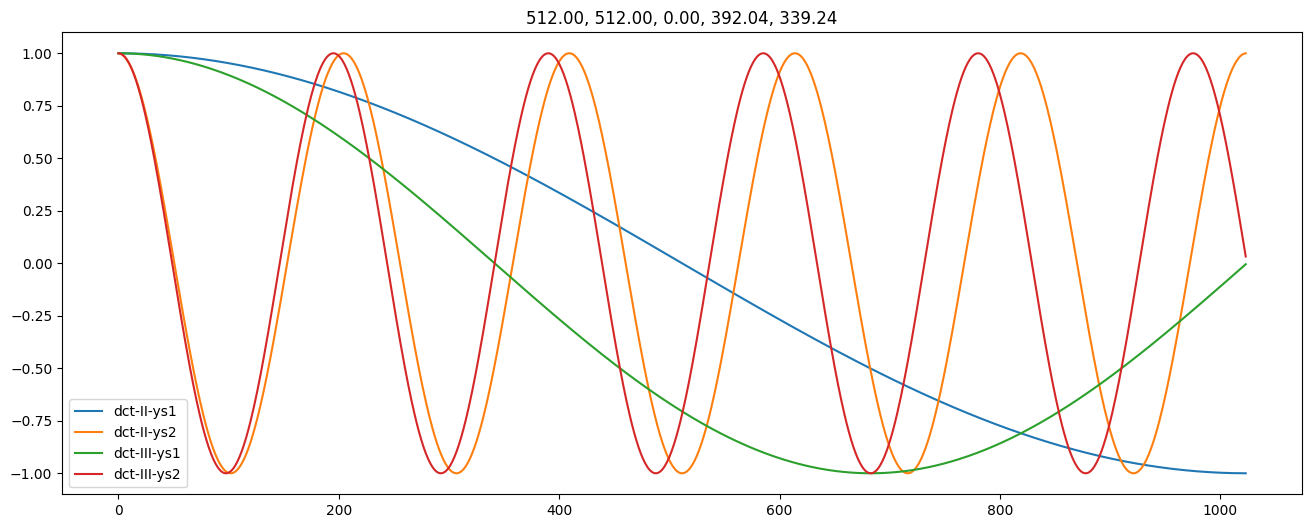

In [1128]:
N = 1024
k1 = 1
k2 = 10
ns = np.arange(N)
ys1 = np.cos(np.pi / N * (ns + 1/2) * k1)
ys2 = np.cos(np.pi / N * (ns + 1/2) * k2)
ys1_3 = np.cos(np.pi / N * (k1 + 1/2) * ns)
ys2_3 = np.cos(np.pi / N * (k2 + 1/2) * ns)
plt.figure(figsize=(16, 6))
plt.plot(ns, ys1, label='dct-II-ys1')
plt.plot(ns, ys2, label='dct-II-ys2')
plt.plot(ns, ys1_3, label='dct-III-ys1')
plt.plot(ns, ys2_3, label='dct-III-ys2')
plt.title(f'{ys1 @ ys1:.2f}, {ys2 @ ys2:.2f}, {ys1 @ ys2:.2f}, {ys1 @ ys1_3:.2f}, {ys2 @ ys2_3:.2f}')
plt.legend()
plt.show()

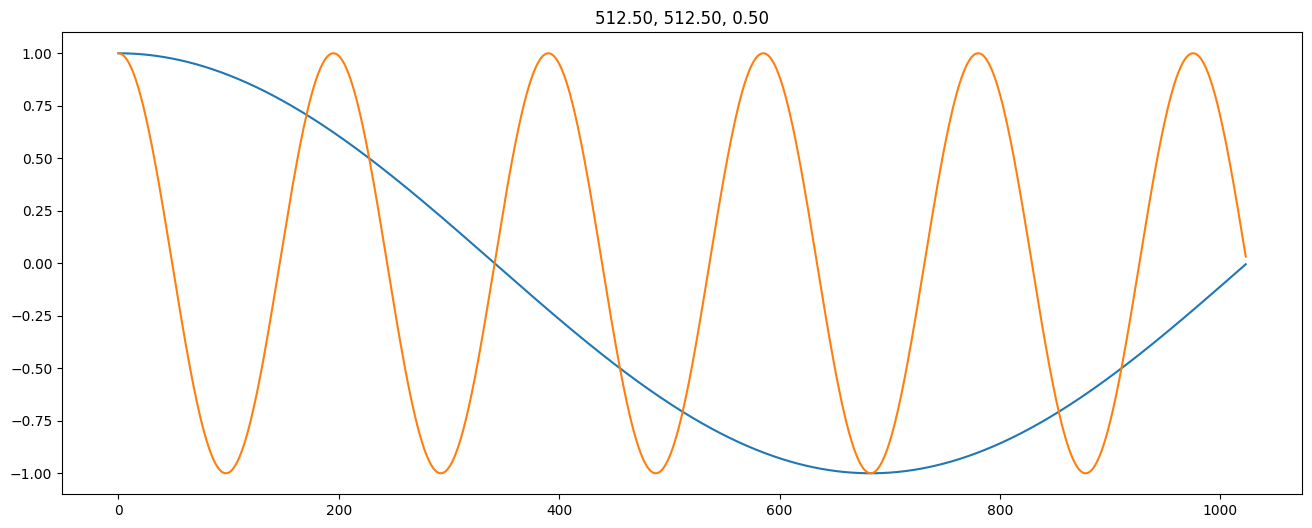

In [1118]:
N = 1024
k1 = 1
k2 = 10
ns = np.arange(N)
ys1 = np.cos(np.pi / N * (k1 + 1/2) * ns)
ys2 = np.cos(np.pi / N * (k2 + 1/2) * ns)
plt.figure(figsize=(16, 6))
plt.plot(ns, ys1)
plt.plot(ns, ys2)
plt.title(f'{ys1 @ ys1:.2f}, {ys2 @ ys2:.2f}, {ys1 @ ys2:.2f}')
plt.show()

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

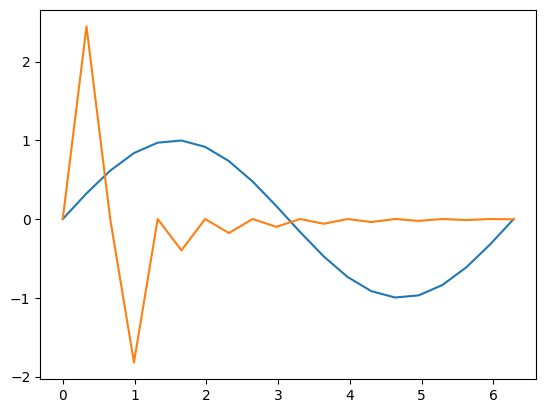

In [1158]:
xs = np.linspace(0, 2 * np.pi, 20)
ys = np.sin(xs)

zs = dct(ys, norm='ortho')

plt.plot(xs, ys)
plt.plot(xs, zs)
plt.show()

In [1152]:
np.round(zs, decimals=2)

array([ 0.  ,  2.44, -0.  , -1.82, -0.  , -0.4 ,  0.  , -0.18, -0.  ,
       -0.1 , -0.  , -0.06,  0.  , -0.04, -0.  , -0.02,  0.  , -0.01,
       -0.  , -0.  ])

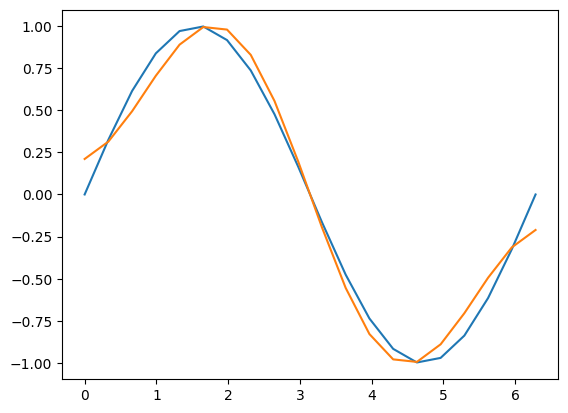

In [1161]:
ys_r = idct(np.where(np.abs(zs) > 0.5, zs, 0), norm='ortho')
plt.plot(xs, ys)
plt.plot(xs, ys_r)
plt.show()

In [1155]:
np.where(np.abs(zs) > 0.5, zs, 0)

array([ 0.        ,  2.44470447,  0.        , -1.82157731,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [50]:
signal.image_id

34